# Performing basic uni- and multivariate statistical analsysis of untargeted metabolomics data

**Updated on:** 2023-08-21 17:33 CEST

In this Jupyter Notebook we perform basic explorative uni- and multivariate statistical analyses of an untargeted metabolomics data set, including data cleaning steps, normalization and batch correction.

<div class="alert alert-block alert-info">

**Authors**: Abzer Kelminal (abzer.shah@uni-tuebingen.de), Francesco Russo (frru@ssi.dk), Filip Ottosson (faot@ssi.dk), Madaleine Ernst (maet@ssi.dk), Axel Walter (axel.walter@uni-tuebingen.de), Carolina Gonzalez (cgonzalez7@eafit.edu.co), Efi Kontou (eeko@biosustain.dtu.dk), Judith Boldt (judith.boldt@dsmz.de) <br>

**Input file format**: .csv files or .txt files <br>
**Outputs**: .csv files, .pdf & .svg images  <br>
**Dependencies**: pandas, numpy, glob, os, re, itertools, plotly, matplotlib, scipy, sklearn, pingouin, skbio, ipyfilechooser, ipywidgets, pynmranalysis, PyComplexHeatmap

The session info at the end of this notebook gives info about the versions of all the packages used here.
</div>

---
<font color = 'red' size =4>**Disclaimer**: This Notebook is compatible with both Jupyter Notebook and Google Colab. However, we advise users with a Windows OS to opt for the Colab version due to potential compatibility issues with certain modules when installed locally on Windows. </font>

---

<b> Before starting to run this notebook with your own data, remember to save a copy of this notebook in your own Google Drive! Do so by clicking on File &rarr; Save a copy in Drive. You can give whatever meaningful name to your notebook.
This file should be located in a new folder of your Google Drive named 'Colab Notebooks'. You can also download this notebook: File &rarr; Download &rarr; Download .ipynb.</b>

---

<b><font color='red' size=4> Please read the comments before proceeding with the code and let us know if you run into any errors and if you think it could be commented better. We would highly appreciate your suggestions and comments!!</font> </b>

# <font color ='blue'> 1. Introduction </font>
<a id='intro'></a>

<p style='text-align: justify;'> The example files used in this tutorial are part of a study published by <a href="https://doi.org/10.1016/j.chemosphere.2020.129450">Petras and coworkers (2021)</a>. Here, the authors investigated the coastal environments in northern San Diego, USA, after a major rainfall event in winter 2017/2018 to observe the seawater chemotype. The dataset contains surface seawater samples collected (−10 cm) at 30 sites spaced approximately 300 meters apart and 50–100 meters offshore along the San Diego coastline from Torrey Pines State Beach to Mission Bay (Torrey Pines, La Jolla Shores, La Jolla Reefs, Pacific and Mission Beach) at 3 different time points: Dec 2017, Jan 2018 (after a major rainfall, resulting in decreased salinity of water) and Oct 2018. As a result of the study, a huge shift was observed in the seawater's organic matter chemotype after the rainfall. <br>

<p style='text-align: justify;'> Seawater samples collected during October 2018, were not published in the original article, but are added to this tutorial to have increased sample size. The datasets used here can be found in the MassIVE repository: <a href="https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=8a8139d9248b43e0b0fda17495387756">MSV000082312</a> and <a href="https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=c8411b76f30a4f4ca5d3e42ec13998dc">MSV000085786</a>. The .mzml files
were preprocessed using <a href="http://mzmine.github.io/">MZmine3</a> and the <a href="https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=b661d12ba88745639664988329c1363e">feature-based molecular networking workflow in GNPS</a>.</p>

<p style='text-align: justify;'> We initially clean the feature table by batch correction, blank removal, imputation, normalization, and scaling. Then we perform multivariate and univariate statistical analyses including supervised classification analysis (Random Forest) and unsupervised learning methods (e.g., PCoA and clustering). Each step is discussed briefly in its own sections.</p>

---

### General Instructions

- **<font color='red'>Text in Red:</font>** This color is used to highlight critical information or indicate cells that require user input. Please pay close attention to these instructions. These instructions guide the user to adapt the notebook for their own datasets without having to modify the code. Cells requiring input will not progress without the user's response. Further details are provided within the notebook itself.

- **User Prompt Guidance:** When encountering code cells subsequent to the highlighted red text, make sure to just run the cell without modifying the code. For example, when you see a code like this:
`data_dir = input("Enter the path of the folder with input files:\n")`. For such prompts, run the code first and provide your answers in the output cell that appears after running the code, not directly within the code itself. This ensures that user input is seamlessly integrated into the subsequent operations.

- **<font color='green'>Text in Green:</font>** Cells with this color contain function blocks. These cells will not produce any visible outputs when run, as they are defining functions for later use in the notebook.

- **Using the '#' Operator:** In the code cells, you may notice lines starting with the '#' symbol. These are comments that describe the function or purpose of a code section. Lines beginning with '#' are "commented out" and will not execute when the cell is run. If you wish to run a commented-out code, simply remove the '#' symbol at the beginning of the line and run the cell again.
---

# <font color ='blue'> 2. Preliminary setup for the notebook </font>
<a id='Section-2'>

## Package installation

### <font color ='darkblue'> Step 1: Installing and loading necessary packages </font>
<a id = 'pkg_install'></a>
Before we start, we need to install all packages needed for our analyses and load the installed packages into our session.

In [ ]:
# Install libraries that are not preinstalled
!pip install pandas numpy plotly scikit-learn scikit-posthocs pingouin kaleido ipyfilechooser nbformat session_info PyComplexHeatmap yellowbrick matplotlib

In [ ]:
#!pip install pandas numpy session_info matplotlib plotly scipy scikit-learn pingouin ipyfilechooser scikit_posthocs PyComplexHeatmap yellowbrick Pillow

In [575]:
# importing necessary modules
import pandas as pd
import numpy as np

import glob
import os
import re
import itertools
import io
import session_info
import shutil
import warnings
import matplotlib.pyplot as plt
import platform
import math
import scipy.stats as stats

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial import distance
from scipy.stats import lognorm
from scipy.stats import shapiro
from scipy.stats import lognorm
from scipy.stats import spearmanr

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import pingouin as pg
from ipyfilechooser import FileChooser
import scikit_posthocs as sp
from PyComplexHeatmap import *
from yellowbrick.cluster import KElbowVisualizer

from PIL import Image

import statsmodels.api as sm

In [ ]:
# Get the operating system information
os_info = platform.system()

# Print the operating system
print(f"The operating system is: {os_info}")

In [ ]:
if os != "Windows":
    !pip install scikit-bio
    import skbio
    from skbio.stats.distance import permdisp
if os !="Windows":
    run the PCoA /PERMAOVA stuff

<font color='red' size= 4 > Installing the following module is not a problem in Google Colab (as it is Linux-based) as well as in macOS and Linux-based systems.</font> scikit-bio is not supported for Windows OS.

In [ ]:
# Don't import on Windows!!
!pip install scikit-bio

In [ ]:
# Don't import on Windows!!
import skbio 
from skbio.stats.distance import permdisp

In [ ]:
# Disable warnings for cleaner output, comment out for debugging
warnings.filterwarnings('ignore')

### <font color ='darkblue'> Step 2: Setting a local working directory </font>
<a name = "set_dir"></a>

<p style='text-align: justify;'> When we set a folder (or directory) as the working directory, we can access the files within the folder just by its names without mentioning the entire file path everytime we use it. Also, all the output files will be saved under the working directory. So, before proceeding with the script further, if you are trying to use your own files for the notebook, then please make sure to include all the necessary input files in one local folder and set it as your working directory. <br/>
<font color='red' size=4> Whenever you see an output box asking for user input, please note, the script will not proceed further without your input. Hence, make sure to run the notebook cell-by-cell instead of running all cells in the notebook simultaneously. </font></p>

<p style='text-align: justify;'> <b>On the Google Colab homepage &rarr; there are several icons in the upper left corner (3 lines, magnifying glass, folder, ...). Click on the 3 lines to see the contents of the notebook. To create a folder for your input files or output files, click on the folder icon → Right-click anywhere on the empty space within the left section in Google Colab → Select 'new folder' → Copy the path and paste in the output box of the next cell<br/>

<font color='red' size=4> Run the cell below and enter the path of the folder containing all your input files in the output cell.</font> <br/>
For example:  
- D:\User\Project\test_data (in case of running the notebook locally)  
- /content/test_data (in Google Colab)

In [ ]:
#enter the directory for the data files:
data_dir = input(r"Enter the path of the folder with input files:\n")
normalized_path = os.path.normpath(data_dir)
os.chdir(normalized_path)

In [ ]:
#enter the directory for the results:
result_dir = input("Enter the path of the folder for all output files:\n")

---
## Data import
<a name='load_ip'></a>

<b><u>Files needed for running the Notebook:</b></u>  

1) <b>Feature table:</b> A typical output file of an LC-MS/MS metabolomics experiment, containing all mass spectral features (or peaks) with their corresponding relative intensities across samples. The feature table we use in this tutorial was obtained from MZmine3. (Filetype: .csv file) <br>

2) <b>Metadata:</b> An Excel file saved in .txt format that is created by the user, providing additional information about the samples (e.g. sample type, tissue type, species, timepoint of collection etc.) In this tutorial we are using the [metadata format recognized by GNPS workflows](https://ccms-ucsd.github.io/GNPSDocumentation/metadata/). The first column should be named 'filename' and all remaining column headers should be prefixed with ATTRIBUTE_: e.g. ATTRIBUTE_Sample_Type, ATTRIBUTE_timepoint etc. (Filetype: .txt file) <br>

Feature table and metadata used in this tutorial can be accessed at <a href="https://github.com/Functional-Metabolomics-Lab/FBMN-STATS/tree/main/data">our Functional Metabolomics Git Repository.</a>

3) <b>OPTIONAL:</b> Annotation files such as GNPS library annotations, GNPS analog annotations, SIRIUS annotations.

<b><u>More on Annotation files:</u></b>  
<p style='text-align: justify;'> If available, provide the files for molecular annotations such as SIRIUS, CANOPUS annotation files. SIRIUS and CANOPUS performs molecular formula prediction and chemical class predictions respectively. GNPS annotation files are obtained as a result of Feature-Based Molecular Networking (FBMN) analysis on the feature table (provided along with its corresponding metadata). <a href="https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=b661d12ba88745639664988329c1363e">The FBMN job is also publicly available.</a> These GNPS annotation files can be directly accessed with their task ID. More on this in <b>step 6</b>.</p>

<b><u>To download the FBMN results locally:</u></b>  
<p style='text-align: justify;'> Go to your <b>MassIVE</b> or <b>GNPS</b> account &rarr; Jobs &rarr; Click on <b>Status</b> of your FBMN Workflow &rarr; Download Cytoscape Data &rarr; A folder will be downloaded. For Ex: "ProteoSAFe-FEATURE-BASED-MOLECULAR-NETWORKING-5877234d-download_cytoscape_data" &rarr; Unzip this folder to access several sub-folders containing files uploaded for FBMN, such as the feature table, metadata table, and graphml file for visualizing the molecular network (found under the folder "gnps_molecular_network_graphml").
<br/> FBMN also offers the option to annotate compounds through GNPS spectral library search or an advanced analog search. These annotated files can be found in the sub-folders <b>"DB_result"</b> and <b>"DB_analog_result"</b> (if analog search is performed). During analog search, the method searches for structurally related molecules within the molecular network using a score threshold, such as a minimum cosine score that MS/MS spectra should achieve in spectral matching with MS/MS spectral libraries to be considered an annotation. In the given example, GNPS annotation annotated 255 compounds, while analog search annotated 1987 compounds. However, it is important to assess the analog annotations by looking at the cosine score and mirror match accuracy. </p>

[![More on MZmine](https://img.shields.io/badge/More%20on-MZmine-blue)](https://www.nature.com/articles/s41587-023-01690-2)
[![More on GNPS](https://img.shields.io/badge/More%20on-GNPS-informational)](https://www.nature.com/articles/nbt.3597#Abs2)
[![More on FBMN](https://img.shields.io/badge/More%20on-FBMN-blue)](https://www.nature.com/articles/s41592-020-0933-6)
[![More on SIRIUS](https://img.shields.io/badge/More%20on-SIRIUS-blue)](https://boecker-lab.github.io/docs.sirius.github.io/)

---

### <font color ='darkblue'> Step 3: Uploading Files to Google Colab </font>

To upload files into Google Colab &rarr; Right-click on the folder you created to 'upload' the necessary files from your computer into the cloud session.

### <font color ='darkblue'> Step 4: Select a Data Loading Method (Choose One Option from Sections 4.1 to 4.3) </font>

In this step, you will need to select one of the available methods for loading your data. You can choose from the following options provided in sections 4.1 to 4.3. Please refer to the relevant section for detailed instructions on the method you choose.

### Step 4.1: Loading files from a local folder

Please make sure to include all the necessary input files in the folder you have set as input directory

In [ ]:
# List all the files in the current working directory
file_names = os.listdir('.')

# Loop through file_names and print each filename
for i, filename in enumerate(file_names):
    print("[", i, "]", filename)

<p style='text-align: justify;'>
  Here, we are importing: the feature table (<b>ft</b>), the metadata table (<b>md</b>), and the annotation tables (<b>an</b>). In our example dataset, we are loading in both GNPS and analog results from FBMN as our annotation files. When importing each file, it is important to ensure that the separator used is specified correctly. <b>By default, the pd.read_csv function uses a comma (',') as the separator. However, in some regions, the separator could be a semicolon (';'). The following code looks for that as well and loads the file accordingly. In case you are importing files with different separators other than a comma or semicolon, make sure you change the file and load it again.</b> <br/>
<font color="red" size=4> In the cell below, provide the index number of the respective files. Be careful to input the numbers without any spaces. </font>
</p>

In [ ]:
input_str = input('Enter the index number of the feature table and metadata separated by commas: ')
input_list = input_str.strip().split(',')

ft = pd.read_csv(file_names[int(input_list[0])])
md = pd.read_csv(file_names[int(input_list[1])], sep = "\t")

---
<font color="red" size=4> In the cell below, provide the index number of the annotation files. Be careful to input the numbers without any spaces. </font>

In [ ]:
annotation_choice = input('Do you have both library annotation and analog annotation?> (y/n): ')

if annotation_choice.lower() == 'y':
  input_str = input('Enter the index number of the GNPS library annotation file and the analog annotation files separated by commas: ')
  input_list = input_str.strip().split(',')
  an_gnps = pd.read_csv(file_names[int(input_list[0])], sep = "\t")
  an_analog = pd.read_csv(file_names[int(input_list[1])], sep = "\t")
elif annotation_choice.lower() == 'n':
  input_num = int(input('Enter the index number of the GNPS annotation file: '))
  an_gnps = pd.read_csv(file_names[int(input_num)], sep = "\t")
  an_analog = an_gnps # If only GNPS is provided, analog will be the same
else:
  print('Invalid input. Please rerun the cell and enter y or n.')

---
<font color="red" size=4> If you also have SIRIUS annotation file, provide the index number of the file in the cell below.</font>

In [ ]:
sirius_choice = input('Do you have SIRIUS annotation file? (y/n): ')

if sirius_choice.lower() == 'y':
    input_str = input('Enter the index number of the SIRIUS annotation file: ')
    sirius = pd.read_csv(file_names[int(input_str)], sep = "\t")
elif sirius_choice.lower() == 'n':
    print('Proceed with the next steps.')
else:
  print('Invalid input. Please rerun the cell and enter y or n.')

Once the files are loaded, you can view the files as shown in [step 5](#view_ip)

### Step 4.2: Loading files using URL

<p style='text-align: justify;'> In this section, we provide an example of how to retrieve data from a URL. Here, we are accessing the same feature table, metadata, gnps result, and analog result files directly from our Functional Metabolomics GitHub page and importing them into python. If you are working with your own dataset in a Google Colab environment, you can obtain the file URL by first loading the input files into the Colab workspace, right-clicking on the file, selecting "Copy path", and then replacing the URL in the subsequent cell.</p>

In [ ]:
#Reading the input data using URL
ft_url = 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/FBMN-STATS/main/data/SD_BeachSurvey_GapFilled_quant.csv'
md_url = 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/FBMN-STATS/main/data/20221125_Metadata_SD_Beaches_with_injection_order.txt'
an_gnps_url = 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/FBMN-STATS/main/data/GNPS_result_FBMN.tsv'
an_analog_url = 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/FBMN-STATS/main/data/GNPS_analog_result_FBMN.tsv'

### Step 4.3: Loading files directly from GNPS
<a id = 'gnps_files'></a>

One can also load the files directly from the repositories [MassIVE](https://massive.ucsd.edu/ProteoSAFe/static/massive.jsp) or [GNPS](https://gnps.ucsd.edu/ProteoSAFe/static/gnps-splash.jsp). If one has performed FBMN on their feature table, the files (both, input and output files from FBMN) can be accessed by  providing the task ID in the next cell. Task ID can be found as follows:  Go to your <b>MassIVE</b> or <b>GNPS</b> account &rarr; Jobs &rarr; unique ID is provided for each job in the 'Description' column.

<table>
<thead>
<tr><th>Description</th><th>User</th><th>Workflow</th><th>Workflow Version</th><th>Status</th><th>Protected</th><th>Create Time</th><th>Total Size</th><th>Site</th><th>Delete Task</th></tr>
</thead>
<tbody>
<tr><td><font color="red">ID given here</font></td><td>-</td><td>FBMN</td><td>-</td><td>-</td><td>-</td><td>-</td><td>-</td><td>GNPS</td><td>-</td></tr>
</tbody>
</table>

<font color="red" size=4> Provide the next cell with the task ID of your FBMN job.</font> Here, we have used the task ID 'b661d12ba88745639664988329c1363e' of the example dataset.

In [ ]:
taskID = input('Enter the task ID of your Feature-Based Molecular Networking Job: ')

ft_url = os.path.join('https://proteomics2.ucsd.edu/ProteoSAFe/DownloadResultFile?task='+taskID+'&file=quantification_table_reformatted/&block=main')
md_url = os.path.join('https://proteomics2.ucsd.edu/ProteoSAFe/DownloadResultFile?task='+taskID+'&file=metadata_merged/&block=main')
an_gnps_url = os.path.join('https://proteomics2.ucsd.edu/ProteoSAFe/DownloadResultFile?task='+taskID+'&file=DB_result/&block=main')
an_analog_url = os.path.join('https://proteomics2.ucsd.edu/ProteoSAFe/DownloadResultFile?task='+taskID+'&file=DB_analogresult/&block=main')

<font color = "purple"><b> ▲ CRITICAL: </b></font>Make sure your metadata has enough columns (ATTRIBUTES) describing your data. The metadata given for FBMN might contain only few columns, however for downstream statistical analysis one might need more attributes. In such cases, load the metadata file from a local folder.

### Reading the url from steps 4.2, 4.3

In [ ]:
ft = pd.read_csv(ft_url)
md = pd.read_csv(md_url, sep = "\t")
an_gnps = pd.read_csv(an_gnps_url, sep = "\t")
an_analog = pd.read_csv(an_analog_url, sep = "\t")

### <font color ='darkblue'>  Step 5: Exploring the Imported Files </font>
<a id='view_ip'></a>

Lets check how the data looks, the below lines of code show the first 5 rows of the feature and metadata tables, and the first 2 rows of the annotation tables, as well as the dimensions of all tables (numbers of rows and columns)

In [ ]:
print('Dimension: ', ft.shape) #gets the dimension (number of rows and columns) of ft
ft.head() # gets the first 5 rows of ft

In [ ]:
print('Dimension: ', md.shape)
md.head()

In [ ]:
an_gnps.head(n=2)

In [ ]:
an_analog.head(n=2)

In [ ]:
print('Dimension: ', an_gnps.shape)
print('Dimension: ', an_analog.shape)

Out of the 11217 features, we found 260 hits using GNPS library and around 2000 hits using analog search.

---
#### Summarizing the metadata

<p style='text-align: justify;'>Before starting with our analysis, we take a look at our metadata. For this purpose, we have created a function. A function is a collection of commands, which takes one or multiple input variables and creates a corresponding output. By creating functions, we avoid having to write big code chunks multiple times. Instead, we can call a sequence of code lines by their function name.</p>
    
<p style='text-align: justify;'><font color= 'green' size= 4>  The following cell is only defining the function 'InsideLevels' and will not produce any immediate output. The input is a metadata table and the output consists of a summary dataframe of our metadata. </font></p>

In [ ]:
def InsideLevels(df):
    # get all the columns (equals all attributes) -> will be number of rows
    levels = []
    types = []
    count = []
    for col in df.columns:
        types.append(type(df[col][0]))
        levels.append(sorted(set(df[col].dropna())))
        tmp = df[col].value_counts()
        count.append([tmp[levels[-1][i]] for i in range(len(levels[-1]))])
    return pd.DataFrame({"ATTRIBUTES": df.columns, "LEVELS": levels, "COUNT":count, "TYPES": types}, index=range(1, len(levels)+1))

Let's have a look at our metadata, with the above defined function InsideLevels.

In [ ]:
len(md.columns) #number of columnns of metadata

In [ ]:
InsideLevels(md)

<p style='text-align: justify;'> The above table is a summary of our metadata tabel. For example, the 2nd row says that there are 2 different types of samples under 'ATTRIBUTE_Sample_Type', namely "Blank" and "Sample". The number of files corresponding to each of these categories is given in the COUNT column. For example, we have 6 files belonging to the "Blank" sample type and 180 files to the "Sample" sample type. </p>

---
## Merging annotations with feature table

### <font color ='darkblue'>  Step 6: Identifying Appropriate Columns for Merging </font>
    
The first column in feature table: <b>row ID</b> (the unique ID for each detected feature) is given in different columns in different files: <br>
* In GNPS result and GNPS analog result files, the row ID is given in the column: <b>#Scan#</b> ('Compound_Name' column has the annotation information)
* For SIRIUS and CANOPUS summary files, the row ID of the feature table is given in the column <b>id</b>. A typical feature id would be: "3_ProjectName_MZmine3_SIRIUS_1_16", where the last number 16 representing the row ID.

### <font color ='darkblue'> Step 7: Ensuring Data Compatibility </font>

<p style='text-align: justify;'> Annotating features in a feature table is useful for identifying metabolites that correspond to those features. This can help to understand the biological relevance of the features, thereby assisting in the interpretation of our metabolomics data. Here, we will show how to merge ft and an (analog annotation file) based on the above-mentioned columns. This merged table can be used later, when needed. Before merging two dataframes based on certain columns, make sure that the classes of both columns are the same. Even if the values are the same, but one column is of numeric class and the other of character class, this might cause unwanted errors. </p>

In [ ]:
#checking if both columns are of similar class
ft["row ID"].dtype== an_gnps["#Scan#"].dtype # for feature table and the GNPS result table

In [ ]:
ft["row ID"].dtype== an_analog["#Scan#"].dtype # for feature table and the GNPS analog result table

### <font color ='darkblue'>  Step 8: Merging Annotations </font>

<b> Merge the annotations from GNPS: Actual library hits and analogs.</b> This is given in <b>'an_final'</b> dataframe. The compound names of 'an_gnps' and 'an_analog' are combined by a separator ';'. As a result, for each #Scan#, we have a single associated compound name. This result is given in <b>'an_final_single' dataframe.</b>

In [ ]:
# Rename the columns of 'an_analog' with a prefix 'Analog' (excluding the '#Scan#' column)
an_analog.columns = ['Analog_' + col if col != '#Scan#' else col for col in an_analog.columns]

# Merge 'an_analog' with 'an_gnps' using a full join on the '#Scan#' column
an_final = pd.merge(an_gnps, an_analog, on='#Scan#', how='outer')

# Consolidate multiple annotations for a single '#Scan#' into one combined name
def combine_names(row):
    if row['Compound_Name'] == row['Analog_Compound_Name']:
        return row['Compound_Name']
    return ';'.join([str(row['Compound_Name']), str(row['Analog_Compound_Name'])])

an_final_single = an_final.groupby('#Scan#').apply(lambda group: pd.Series({
    'Combined_Name': combine_names(group.iloc[0])
})).reset_index()

# To get the DataFrame with that exact column name (without automatic renaming)
an_final_single.columns = an_final_single.columns.str.replace('.', '_')

In [ ]:
print('Dimension: ', an_final.shape)
an_final.head(n=2)

In [ ]:
# Save the DataFrame to CSV, including the index (row names) as a column
an_final.to_csv(os.path.join(result_dir, 'GNPS_LibraryHits_AnalogHits_Merged.csv'), index=True)

In [ ]:
an_final_single # the merged annotation table with the combined names

This annotation information is then merged with the feature table.

In [ ]:
ft_an = ft.merge(an_final_single, left_on= "row ID",  how='left', right_on= "#Scan#", sort=True)
print('Dimension: ', ft_an.shape)
ft_an.head()

<b> OPTIONAL: </b>In case you have SIRIUS annotations as well, the following code cell can be used to get a final output 'merged_data' which contains all the annotations in one table. This can be used later for further data exploration.

In [ ]:
if sirius_choice.lower() == 'y':
     # when'sirius' file exists
    sirius['row ID'] = sirius['id'].apply(lambda x: int(re.search("(?<=_)[^_]+$", x).group()))  # Extract 'row ID' from 'id' in 'sirius'
    sirius = sirius.drop(columns=['id'])  # Drop 'id' column from 'sirius'
    sirius.columns = ['SIRIUS_' + col if col != 'row ID' else col for col in sirius.columns]

    # Assuming 'an_final' exists
    an_final = an_final.rename(columns={'#Scan#': 'row ID'})  # Rename '#Scan#' column to 'row ID' in 'an_final'

    # Merge 'an_final' with 'sirius' on 'row ID'
    merged_data = pd.merge(an_final, sirius, on='row ID', how='outer')

    # Save merged data to CSV
    merged_data.to_csv(os.path.join(result_dir, 'Merged_Annotations_GNPS_SIRIUS.csv'), index=True)
    merged_data.head()

---
## Arranging metadata and feature table in the same order

<p style='text-align: justify;'> In the next cells, we bring feature table and metadata in the correct format such that the rownames of the metadata and column names of the feature table are the same. Filenames and the order of files need to correspond in both tables, as we will match metadata attributes to the feature table. In that way, both metadata and feature table, can easily be filtered. </p>

### <font color ='darkblue'>  Step 9: Creating Backup Files </font>

In [ ]:
new_md = md.copy() #storing the files under different names to preserve the original files
new_ft = ft.copy()

### <font color ='darkblue'> Step 10: Cleaning the files </font>

In [ ]:
new_ft.columns = new_ft.columns.str.replace(' Peak area', '') # Removing " Peak area" extensions from the column names of new_ft
new_ft = new_ft.sort_values(by='row ID') # Arranging the rows of new_ft by ascending order of "row ID"

new_ft = new_ft.loc[:, new_ft.notna().sum() > 0] # Removing columns in new_ft where all values are NaN
new_md = new_md.loc[:, new_md.notna().sum() > 0] # Removing columns in new_md where all values are NaN

new_md = new_md[new_md.apply(lambda row: all(item != "" for item in row), axis=1)] # Remove rows where all the elements are empty strings
new_md = new_md.applymap(lambda x: x.strip() if isinstance(x, str) else x) # Remove leading and trailing spaces from each column of new_md

### <font color ='darkblue'> Step 11: Update the row names of feature table </font>

In [ ]:
# Check if "ft_an" exists and compare "row ID" columns if it does
if 'ft_an' in globals():
    comparison_result = (ft_an['row ID'].values == new_ft['row ID'].values).all()
    print(comparison_result)  # Should print True if you have an annotation file

# Changing the index (row names) of new_ft into the combined name as "XID_mz_RT":
new_name = 'X' + new_ft['row ID'].astype(str) + '_' + new_ft['row m/z'].round(3).astype(str) + '_' + new_ft['row retention time'].round(3).astype(str)
new_name_values = new_name.values

if 'ft_an' in globals():
    combined_name_ft = ft_an['Combined_Name'].astype(str).values
    underscore_added = ['_' + x for x in combined_name_ft] #add a underscore prefix
    new_name_values = np.core.defchararray.add(new_name_values.astype(str), underscore_added)

# Set the new index and remove trailing underscore if present
new_ft.index = new_name_values

In [ ]:
new_ft.head(n=2)

In [ ]:
new_md.head(n=2)

<p style='text-align: justify;'> After adding the annotation information, the feature table "new_ft" now includes the annotation in the row names of the features. This can be beneficial for downstream analysis, such as univariate statistics, where significant features can be easily identified if they are annotated. Similarly, in supervised analysis like Random Forest, the annotated compound driving the classification can be quickly assessed. This will be further highlighted in the respective univariate and multivariate sections. </p>

### <font color ='darkblue'> Step 12: Selecting Relevant Columns </font>

In [ ]:
# Selecting only the columns with names containing 'mzXML' or 'mzML'
new_ft = new_ft.loc[:, new_ft.columns.str.contains('\\.mzXML$|\\.mzML$')]

# If either .mzXML or .mzML files are present, print a message
if new_ft.columns.str.contains('\\.mzXML$').any() and new_ft.columns.str.contains('\\.mzML$').any():
    print("Both .mzXML and .mzML file types are present in the data")

In [ ]:
# Checking the files again to see if the above changes have been made:
print('Dimension: ', new_ft.shape)
new_ft.head(n=2)

In [ ]:
print('Dimension: ', new_md.shape)
new_md.head(n=2)

### <font color ='darkblue'> Step 13: Verifying File Consistency </font>

In [ ]:
new_ft = new_ft.reindex(columns=sorted(new_ft.columns)) # Ordering the columns of 'new_ft' by their names
new_md = new_md.sort_values(by='filename').reset_index(drop=True) #ordering the md by the 1st column filename

In [ ]:
# how many files in the metadata are also present in the feature table
new_md['filename'].isin(new_ft.columns).value_counts()  #if this returns False it means some files are missing

The output says that all 186 files are present in both new_md & new_ft. Furthermore, metadata filenames and feature table column names are identical, indicating that they are in the same order. If the above lines returns FALSE, it means some files are missing. To check names of the files that are missing we can run the next cell. If everything went well, the next cell should return the statement that all files are present in both new_md & new_ft.

In [ ]:
# check if new_ft column names and md row names are the same
if sorted(new_ft.columns) == sorted(new_md['filename']):
    print(f"All {len(new_ft.columns)} files are present in both new_md & new_ft.")
else:
    print("Not all files are present in both new_md & new_ft.\n")
    # print the md rows / ft column which are not in ft columns / md rows and remove them
    ft_cols_not_in_md = [col for col in new_ft.columns if col not in new_md['filename']]
    print(f"These {len(ft_cols_not_in_md)} columns of feature table are not present in metadata table and will be removed:\n{', '.join(ft_cols_not_in_md)}\n")
    new_ft.drop(columns=ft_cols_not_in_md, inplace=True)
    md_rows_not_in_ft = [row for row in new_md['filename'] if row not in new_ft.columns]
    print(f"These {len(md_rows_not_in_ft)} rows of metadata table are not present in feature table and will be removed:\n{', '.join(md_rows_not_in_ft)}\n")
    new_md.drop(md_rows_not_in_ft, inplace=True)

When the above cell returns some filenames, check the corresponding column names in the feature table for spelling mistakes, case-sensitive errors. Reupload the files with correct metadata and rerun the above steps.

In [ ]:
#checking the dimensions of our new ft and md:
print("The number of rows and columns in our original ft is:", ft.shape,"\n")
print("The number of rows and columns in our new ft is:", new_ft.shape,"\n")
print("The number of rows and columns in our new md is:", new_md.shape)

Notice that the number of columns of the new feature table is the same as the number of rows in our new metadata. Now, we have both our feature table and metadata in the same order.

---

# <font color ='blue'> 3. Data-cleanup </font>

### <font color ='darkblue'> Step 14: Transposing the feature table </font>
As a first step of data-cleanup step, lets merge the metadata and feature table (transposed) together. This can be used later for other purposes such as batch correction.

In [ ]:
ft_t = pd.DataFrame(new_ft).T #transposing the ft
ft_t = ft_t.apply(pd.to_numeric) #converting all values to numeric
np.array_equal(new_md['filename'],ft_t.index) #should return True now

In [ ]:
ft_t.head(n=3)

In [ ]:
#merging metadata (new_md) and transposed feature table based on the sample names
ft_merged_with_md = pd.merge(new_md, ft_t.reset_index(), left_on='filename', right_on='index', how='left')
ft_merged_with_md.head(n=2)

In [ ]:
ft_merged_with_md.to_csv(os.path.join(result_dir,"Ft_md_merged.csv")) # This file can be used for batch correction

<div class="alert alert-block alert-warning">
<b><font size=3> Skip the Batch correction section if you do not have multiple batches !! </font> </b> </div>

## Batch Correction (Optional)
<a id="batch_corr"></a>

<p style='text-align: justify;'> A 'Batch' is a group of samples processed and analyzed by the same experimental & instrumental conditions in the same short time period. In general, if we have more samples than the tray size, we might measure them as multiple batches or groups. When arranging samples in a batch for measurement, in order to ensure biological diversity within a batch, in addition to our samples of interest, it is advised to have QCs, blanks, and controls (Wehrens et al., 2016). To merge data from these different batches, we must look for batch-effects, both, between the batches and within each batch and correct these effects. <b>But, prior to batch correction on a dataset, we should evaluate the severity of the batch effect and when it is small, it is best to not perform batch correction as this may result in an incorrect estimation of the biological variance in the data. Instead, we should treat the statistical results with caution (Nygaard et al., 2016). For more details, please read the manuscript </b>.</p>

<p style='text-align: justify;'> In this tutorial, the test dataset was utilized to evaluate the chemical impacts of a significant rain event that occurred in northern San Diego, California (USA) during the Winter of 2017/2018. Despite the presence of a "ATTRIBUTE_Batch" column in the metadata, the 3 groups mentioned are not considered as batches due to their distinct collection conditions. The "ATTRIBUTE_time_run" column clearly indicates that the seawater samples were collected and measured at different times during Dec 2017, Jan 2018 (after rainfall), and Oct 2018, respectively. Also, they were collected 'before' and 'after' rainfall. Therefore, searching for inter-batch effects is not meaningful in our example dataset. In terms of intra-batch effect, since the sample dataset does not have QCs, we cannot correct for the intra-batch effect.</p>

Follow the notebook for Batch Correction: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Functional-Metabolomics-Lab/FBMN-STATS/blob/main/Individual_Notebooks/R-Notebooks/Batch_Correction.ipynb)

## Blank removal
<a id="blank_rem"></a>

<p style='text-align: justify;'> Blank samples contain no analytes of interest and consist, for example, of the solvent, matrix, tissue or growth media that was used to prepare or dissolve the samples and analytes of interest. Such as the analytes, the mass spectral features deriving from blank samples are also detected by the LC-MS/MS instrument.
We need to remove these blank features to obtain accurate results.</p>

<p style='text-align: justify;'>To eliminate these blank features, we initially split the feature table into blanks and samples, and then employ a cutoff filter. Next, we compute the average feature intensities for the blanks and samples, and subsequently calculate the ratio of average_feature_blanks to average_feature_sample. We compare this ratio against the user-defined cutoff to determine which features to be removed. When the cutoff is set to 0.3, it implies that for any feature, up to 30% contribution from the blank and 70% from the sample are allowed. Hence any feature with a ratio greater than 0.3 is removed. By using a lower cutoff, such as 10% (0.1), we would demand a greater contribution from the sample (90%) and restrict the blank's contribution to 10%. Raising the cutoff leads to fewer background features being identified and more analyte features being observed. Conversely, lowering the cutoff is more rigorous and leads to the removal of more features.</p>

### <font color ='darkblue'>  Step 15: Examine Metadata Attributes </font>

In order to remove blank features from our samples, we first split our feature table into blanks and samples using the metadata and our InsideLevels function created in [step 7](#explore_md).

In [ ]:
InsideLevels(new_md.iloc[:, 1:]) #skipping the 0th column (filename) and looking at the summary table

### <font color ='darkblue'>  Step 16: Separate Sample and Blank Files </font>
<font color="red" size=4> For your metadata summary above, enter the index number for your 'sample-type' column as well as the index numbers for the blank and sample. </font>

In [ ]:
sample_index = int(input('Enter the index number of the attribute containing sample and blanks information: '))
sample_attribute = new_md.columns[sample_index]

df = pd.DataFrame({"LEVELS": InsideLevels(new_md.iloc[:, 1:]).iloc[sample_index-1]["LEVELS"]})
df.index = [*range(1, len(df)+1)]
display(df)

#Among the shown levels of an attribute, select the ones to keep
blank_name = InsideLevels(new_md.iloc[:,1:]).iloc[sample_index-1]['LEVELS'][int(input('Enter the index number of the blanks: ')) - 1]
sample_name = InsideLevels(new_md.iloc[:,1:]).iloc[sample_index-1]['LEVELS'][int(input('Enter the index number of the samples: ')) - 1]

In [ ]:
md_Blank = new_md[new_md[sample_attribute] == blank_name]
Blank = ft_t[ft_t.index.isin(md_Blank['filename'])]

md_Samples  = new_md[new_md[sample_attribute] == sample_name]
Samples = ft_t[ft_t.index.isin(md_Samples['filename'])]

In [ ]:
# Display the chosen blanks
print('Dimension: ',Blank.shape)
Blank.head(2)

In [ ]:
# Display the chosen samples
print('Dimension: ',Samples.shape)
Samples.head(2)

### <font color ='darkblue'> Step 17: Define Cutoff for Blank Features Removal </font>

Now that we have our feature table split into blanks and samples, we can start removing blank features. **<font color='red'> We use a cutoff of 0.3 </font>**, meaning that in order for a feature to be considered of interest, it needs to have a ratio of average_feature_blanks vs average_feature_sample <30%. </font> </br>
<font color='red' size = 4>In the below cell you can interactively change the threshold to any value between 0.1 and 1. </font>

In [ ]:
Cutoff = float(input('Enter Cutoff value between 0.1 & 1 (Ideal cutoff range: 0.1-0.3):')) # Input cutoff value

### <font color ='darkblue'> Step 18: Perform Blank Removal </font>

In [ ]:
# Getting mean for every feature in blank and Samples in a DataFrame named 'Avg_ft'
Avg_ft = pd.DataFrame({'Avg_blank': Blank.mean(axis=0, skipna=False)}) # Set skipna=False to check if there are NA values
Avg_ft['Avg_samples'] = Samples.mean(axis=0, skipna=False) # Adding another column 'Avg_samples' for feature means of samples

# Getting the ratio of blank vs Sample
Avg_ft['Ratio_blank_Sample'] = (Avg_ft['Avg_blank'] + 1) / (Avg_ft['Avg_samples'] + 1)

# Creating a bin with 1s when the ratio > Cutoff, else put 0s
Avg_ft['Bg_bin'] = (Avg_ft['Ratio_blank_Sample'] > Cutoff).astype(int)

# Calculating the number of background features and features present
print("Total no.of features:", Avg_ft.shape[0])
print("No.of Background or noise features:", Avg_ft['Bg_bin'].sum())
print("No.of features after excluding noise:", (Samples.shape[1] - Avg_ft['Bg_bin'].sum()))

# Merging Samples with Avg_ft and selecting only the required rows and columns
blk_rem = pd.concat([Samples.T, Avg_ft], axis=1, join='inner')
blk_rem = blk_rem[blk_rem['Bg_bin'] == 0]  # Picking only the features
blk_rem = blk_rem.drop(columns=['Avg_blank', 'Avg_samples', 'Ratio_blank_Sample', 'Bg_bin'])  # Removing the last 4 columns
blk_rem = blk_rem.T


**Review the blank removed table**:

In [ ]:
print('Dimension: ',blk_rem.shape)
blk_rem.head(n=3)

In [ ]:
# metadata without the blanks info:
print('Dimension: ', md_Samples.shape)
md_Samples.head(n=3)

In [ ]:
blk_rem.to_csv(os.path.join(result_dir, "Blanks_Removed_with_cutoff_"+ str(Cutoff) + ".csv"))

---
## Imputation
<a name = 'imp'></a>

<p style='text-align: justify;'> For several reasons, real world datasets might have some missing values in it, in the form of NA, NANs or 0s. Eventhough the gapfilling step of MZmine fills the missing values, we still end up with some missing values or 0s in our feature table. This could be problematic for statistical analysis. We cannot simply discard those rows or columns with missing values as we will lose valuable data. Instead we can try imputing or replacing the missing values in the data with a meaningful, reasonable guess. Here, first, we use the blank-removed feature table to assess frequencies across relative intensities. The plot from the below cell shows us how many features have which relative intensities. We then create random values between 0 and the minimum value in our blank-removed table and randomly replace all 0s with these random values. </p>

### <font color ='darkblue'> Step 19: Analyzing the frequency distribution of relative intensities </font>
<a name="imp_freq"></a>

In [ ]:
bins, bins_label, a = [-1, 0, 1, 10], ["-1","0", "1", "10"], 2

while a<=10:
    bins_label.append(np.format_float_scientific(10**a))
    bins.append(10**a)
    a+=1

freq_table = pd.DataFrame(bins_label)
frequency = pd.DataFrame(np.array(np.unique(np.digitize(blk_rem.T.to_numpy(), bins, right=True), return_counts=True)).T).set_index(0)
freq_table = pd.concat([freq_table,frequency], axis=1).fillna(0).drop(0)
freq_table.columns = ["intensity", "Frequency"]
freq_table["Log(Frequency)"] = np.log(freq_table["Frequency"]+1)

# get the lowest intensity (that is not zero) as a cutoff LOD value
cutoff_LOD = round(blk_rem.replace(0, np.nan).min(numeric_only=True).min())

fig = px.bar(freq_table, x="intensity", y="Log(Frequency)", template="plotly_white",  width=600, height=400)

fig.update_traces(marker_color="#696880")
fig.update_layout(font={"color":"grey", "size":12, "family":"Sans"},
                  title={"text":"Frequency plot - Gap Filled", "x":0.5, "font_color":"#3E3D53"},
                  xaxis_title= "Range")

fig.write_image(os.path.join(result_dir, "frequency_plot.svg"))

fig.show()

The above histogram shows that, in our, blank-removed feature table, there are many zeros present. And no values in the range between 0 to 1E2. The minimum value greater than 0 in our dataframe is in between 1E2 & 1E3 (and that value is 892).

### <font color ='darkblue'> Step 20: Random Value Generation & Zero Replacement </font>

In [ ]:
# Set the seed for random number generation
np.random.seed(141222)

imp = blk_rem.copy()
imp = imp.applymap(lambda x: np.random.randint(1, cutoff_LOD) if x == 0 else x)

In [ ]:
print('Dimension: ', imp.shape)
imp.head(n=3)

In [ ]:
(imp == 0).sum().sum() # checking if there are any zeros in our imputed table

In [ ]:
imp.to_csv(os.path.join(result_dir, 'Imputed_QuantTable.csv')) # save to file

## Normalization
<a id="norm"></a>

Normalization is performed to compensate for differences in total metabolite concentrations among samples (Y. Wu & Li,2016). Many normalization techniques can also correct the batch effects, such as those caused by sample pipetting or extraction. Here, we present 2 types of normalization: Total Ion Current(TIC) or (Probabilistic Quotient Normalization) PQN.

### <font color ='darkblue'> Step 21: Total Ion Current (TIC) or sample-centric normalization </font>
<a name="tic"></a>

<p style='text-align: justify;'> TIC is a simple normalization technique that is commonly used as it is easy to implement and computationally inexpensive. It scales the intensities of all features in a sample by the total ion current (or sum) of the sample. TIC normalization is appropriate when the volume of sample injected into the instrument is consistent across all samples, and when the differences in the total ion count among samples are mainly due to differences in the concentration of sample injected. However, TIC has its limitation such as few features with high ion observation can heavily influence the calculation. Also it assumes most metabolites are stable and equally up/down-regulated among samples, which does not hold true in cases like normal vs cancerous tissues comparison. </p>

In [ ]:
normalized = imp.copy()

# Dividing each element of a particular row (as each row is the sample) with its row sum
norm_TIC = normalized.apply(lambda x: x/np.sum(x), axis=1)

print('No NA values in Normalized data:',norm_TIC.isnull().values.any() == False)
print('Dimension: ', norm_TIC.shape)
norm_TIC.head(n=3)

In [ ]:
norm_TIC.to_csv(os.path.join(result_dir, "Normalised_TIC_Quant_table.csv")) # save to file

### <font color ='darkblue'> Step 22: Probabilistic Quotient Normalization (PQN) </font>
<a name="pqn"></a>

This step is only available in the R Notebook and not available in Python Notebook.

---
## Scaling
<a name='scaling'></a>

One can also perform center-scaling after imputation. Scaling is typically done to make sure that the data is centered around 0 and has a consistent spread to adjust for differences in offset between high and low-abundant metabolites, thus leaving only relevant variation for analysis.

In [ ]:
#Setting 'filename' column as 'index' for md_Samples
md_Samples.set_index('filename', inplace=True)
md_Samples.index.name = None

# put the rows in the feature table and metadata in the same order
imp.sort_index(inplace=True)
md_Samples.sort_index(inplace=True)

if (md_Samples.index == imp.index).all():
    pass
else:
    print("WARNING: Sample names in feature and metadata table are NOT the same!")

### <font color ='darkblue'> Step 23: Center-Scaling </font>

In Python, using the `StandardScaler` class from the `sklearn.preprocessing` module, the user can center and scale the data by subtracting the mean and dividing by the standard deviation (SD).

- The 'fit_transform' function calculates the mean and SD of 'transposed' for later scaling and then transforms 'transposed' based on those statistics. This results in a NumPy array with the scaled values.
- The standardized values are then converted back into a Pandas DataFrame, with the same index and columns as the original 'transposed' DataFrame.
- The 'scaled' DataFrame now contains the same data as 'transposed', but with each feature (column) having a mean of 0 and an SD of 1.

Similar to R, this module allows few operations:

- `with_mean=True` (default): This will center the data by subtracting the mean of each feature. This is equivalent to `center=TRUE` in R's `scale` function.
- `with_std=True` (default): This will scale the data by dividing each feature by its SD. This is equivalent to the case when both `scale=TRUE` and `center=TRUE` are set in R's `scale` function.
- `with_mean=False`: The mean will not be subtracted, but there's no direct equivalent in `StandardScaler` for scaling by the root mean square if centering is not performed

The options in Python's `StandardScaler` are somewhat more limited compared to R's `scale` function.

In [ ]:
# center and scale filtered data
Imp_scaled = pd.DataFrame(StandardScaler().fit_transform(imp),
                      index=imp.index,
                      columns=imp.columns)
Imp_scaled.head(n=2)

In [ ]:
Imp_scaled.to_csv(os.path.join(result_dir, "Imputed_Scaled_QuantTable.csv")) #save the file

### <font color ='darkblue'> Step 24: Choose data for further analysis </font>

In [ ]:
# Define the dataframe of data choices
cleaned_data_choice = pd.DataFrame({
    'INDEX': range(1, 6),
    'Description': ["Raw data", "Blank removed data", "Imputed data", "TIC Normalized", "Scaled"],
    'Variable_name': ["ft_t", "blk_rem", "imp", "norm_TIC", "Imp_scaled"],
    'metadata_name': ["new_md"] + ["md_Samples"] * 4
})

cleaned_data_choice # Display the data choices to the user

<font color="red" size=4> Enter the index number of the table you want to use for further analysis.</font>

In [ ]:
# Get the user's selection
cleaned_data_str = int(input('Enter the index number of the dataframe to use for further analysis: '))

# Retrieve the selected variable and metadata directly
selected_variable = cleaned_data_choice.loc[cleaned_data_str - 1, 'Variable_name']
cleaned_data = globals()[selected_variable]

selected_md =  cleaned_data_choice.loc[cleaned_data_str - 1, 'metadata_name']
metadata = globals()[selected_md]

In [ ]:
cleaned_data.head(n=2)

In [ ]:
metadata.head(n = 2)

---
# <font color ='blue'> 4. Multivariate analysis </font>
<a name="multi"></a>

### <font color ='darkblue'> Step 25: Install Packages for Multivariate Analyses </font>

No packages need to be installed here. All packages are installed in the beginning.

## PCoA PERMANOVA
<a name = 'pcoa'></a>

<p style='text-align: justify;'> <b>Principal coordinates analysis (PCoA)</b> is a metric multidimensional scaling (MDS) method that attempts to represent sample dissimilarities in a low-dimensional space. It converts a distance matrix consisting of pair-wise distances (dissimilarities) across samples into a 2- or 3-D graph. <a href="https://onlinelibrary.wiley.com/doi/10.1002/0470011815.b2a13070">(Gower, 2005)</a></p>
    
<p style='text-align: justify;'> Different distance metrics can be used to calculate dissimilarities among samples (e.g. Euclidean, Canberra, Minkowski). Performing a principal coordinates analysis using the Euclidean distance metric is the same as performing a principal components analysis (PCA). The selection of the most appropriate metric depends on the nature of your data and assumptions made by the metric.</p>

<p style='text-align: justify;'> Within the metabolomics field the Euclidean, Bray-Curtis, Jaccard or Canberra distances are most commonly used. The Jaccard distance is an unweighted metric (presence/absence) whereas Euclidean, Bray-Curtis and Canberra distances take into account relative abundances (weighted). Some metrics may be better suited for very sparse data (with many zeroes) than others. For example, the Euclidean distance metric is not recommended to be used for highly sparse data. </p>

This [video tutorial by StatQuest](https://www.youtube.com/watch?v=GEn-_dAyYME) summarizes nicely the basic principles of PCoA.

### <font color ='darkblue'> Step 26: Prepare Data </font>
In order to perform a PCoA as described below, it is important that the filenames in our metadata are identical as well as in the same order as the filenames in our feature table.

In [ ]:
DataCheck = np.isin(metadata.index, cleaned_data.index)

# Check if all elements are True
if DataCheck.all():
    print("All elements meet the condition")
    print(np.bincount(DataCheck.astype(int)))
else:
    print("Not all elements meet the condition.")

In [ ]:
print('Dimension: ', cleaned_data.shape)
cleaned_data.head(n=2)

### <font color ='darkblue'> Step 27: Calculate Pairwise Distances and  Perform PCoA</font>
<a name="distm"></a>

First, we will calculate pairwise distances across all samples in our data using the Euclidean distance metric. When we use the Euclidean distance, it's referred to as Principal Component Analysis (PCA). For other distance metrics, we refer to it as Principal Coordinates Analysis (PCoA).

In [ ]:
raw_pcoa = distance.squareform(distance.pdist(cleaned_data, metric="euclidean"))
distm = skbio.stats.distance.DistanceMatrix(raw_pcoa, ids=cleaned_data.index)

All pairwise Euclidean distances are now stored within our distance (dissimilarity) matrix (distm). The distance matrix is then used as input for the PCoA.

In [ ]:
#computing multi-dimensional scaling on distance matrix to 10 components
PCoA = skbio.stats.ordination.pcoa(distm, number_of_dimensions=10) # 10 principal coordinates
pcoa_df= PCoA.samples
explained_var= np.round(PCoA.proportion_explained*100, decimals =2)

### <font color ='darkblue'> Step 28: Analyze PCoA Results </font>

‘pcoa_df’ represents the data matrix with the given PCos

In [ ]:
pcoa_df.head(3)

In [ ]:
np.array_equal(pcoa_df.index, metadata.index)

The following scree plot shows the variance explained by each principal component.

In [ ]:
fig_bar = px.bar(x= pcoa_df.columns, y= explained_var, template= "plotly_white",  width=500, height=400)
fig_bar.update_traces(marker_color="#696880", width=0.5)
fig_bar.update_layout(font= {"color":"grey", "size":12, "family":"Sans"},
                    title= {"text":"PCA - Scree Plot", 'x':0.5, "font_color":"#3E3D53"},
                    xaxis_title= "principal component", yaxis_title= "variance explained (%)")
fig_bar.show()

### <font color ='darkblue'> Step 29: Plot PCoA Scores </font>

Here, we can plot our PCA (with the Euclidean distance) or PCoA scores. We show that here with an example by coloring samples according to the month of the year the samples were retrieved (ATTRIBUTE_Month):

In [ ]:
list(metadata)

<font color= 'red' size=4> Change the attribute in the cell below according to your metadata !!! </font>

In [ ]:
interested_attribute_pcoa = 'ATTRIBUTE_Month' # change the attribute here according to your metadata

In [ ]:
def pca_scatter_plot(attribute, attribute_type='categorical'):
    title = f'PCoA plot representing the sample distribution across different groups'
    df = pd.merge(pcoa_df[['PC1', 'PC2']], metadata[attribute].apply(str if attribute_type == 'categorical'
                                                                      else float),
                  left_index=True,
                  right_index=True)

    if attribute_type == 'continuous':
        fig = px.scatter(df, x='PC1', y='PC2', template='plotly_white', width=600, height=400,
                         color=attribute,
                         color_continuous_scale='Viridis')
    else:
        fig = px.scatter(df, x='PC1', y='PC2', template='plotly_white', width=600, height=400,
                         color=attribute)
        
        fig.update_layout(
        font={"color": "grey", "size": 12, "family": "Sans"},
        title={"text": title, 'x': 0.5, "font_color": "#3E3D53", "xanchor": "center"},  # Center title
        xaxis_title=f'PCoA1 {explained_var[0]}%',
        yaxis_title=f'PCoA2 {explained_var[1]}%',
        legend_title_text='',
        legend=dict(
            title=dict(font=dict(size=18, family='bold')),
            itemclick='toggleothers',
            itemdoubleclick='toggle'
        )
    )

    fig.update_traces(marker=dict(size=6))

    fig.show()
    
    # Save the figure with the attribute name as part of the filename
    fig_name = f"{result_dir}/figure_{attribute}.svg"
    fig.write_image(fig_name)

pca_scatter_plot(interested_attribute_pcoa)

This funcion will automatically save the figure with the attribute name as part of the filename into the result directory. You can also download the image (in .png format) manually by hovering over the plot and clicking on the camera icon.

<p style='text-align: justify;'> It looks like there is a strong separation between the chemotypes of seawater sampled during different months. But is the separation significant? Let's perform a permutational multivariate analysis of variance (PERMANOVA) to find out! </p>

### PERMANOVA

<p style='text-align: justify;'> Permutational multivariate analysis of variance (PERMANOVA) is a non-parametric method for multivariate ANOVA, where P-values are obtained using permutations. The metric was originally developed within the field of ecology <a href ='https://onlinelibrary.wiley.com/doi/full/10.1002/9781118445112.stat07841'>(Anderson, 2008)</a> but is today widely used in other fields, including the microbiome and metabolomics field. PERMANOVA is used to compare groups of samples and it tests whether the centroid and/or the spread of the samples is different among the groups. Here, H0 states no differences among the groups and it is rejected when there is a significance difference among the groups. </p>

### <font color ='darkblue'> Step 30: Testing for Homoscedasticity </font>

<p style='text-align: justify;'> Before conducting PERMANOVA, it's essential to check the homogeneity of group dispersions (also known as 'Homoscedasticity'), as PERMANOVA assumes that group dispersions are equal across groups. Violation of this assumption can increase the Type I error rate. We use PERMDISP, similar to Levene's test but for multivariate data, to evaluate whether group dispersions significantly differ. If the resulting p-value is < 0.05, it indicates that the group dispersions are different and the assumption for PERMANOVA is violated. If group dispersions are not significantly different, you can more confidently proceed with PERMANOVA.The PERMDISP performed here is similar to the betadisper function from R's vegan package. 
<a href ="http://scikit-bio.org/docs/0.5.4/generated/generated/skbio.stats.distance.permdisp.html"> More on the function can be found here</a>.</p>

In [ ]:
list(metadata)

<font color = "red"  size =4> Change the attribute in the cell below according to your metadata !!! </font>

In [ ]:
interested_attribute_permanova = 'ATTRIBUTE_Month' # change the attribute here according to your metadata

In [ ]:
group = metadata.loc[:, interested_attribute_permanova]
group.unique()

In [ ]:
raw_pcoa = distance.squareform(distance.pdist(cleaned_data, metric="euclidean")) #compute distance
distm = skbio.stats.distance.DistanceMatrix(raw_pcoa, ids=cleaned_data.index)

In [ ]:
np.random.seed(0)
permdisp(distm, group)

<p style='text-align: justify;'> The resulting p-value is significant (p < 0.05), this indicates that the group dispersions are different for 'ATTRIBUTE_Month'. This violates the PERMANOVA assumption. When PERMANOVA is performed for this attribute, the PERMANOVA results requires a more cautious interpretation. If your resulting p-value from the above anova is not-significant, you can confidently go with PERMANOVA using the following method. </p>

### <font color ='darkblue'> Step 31: Conduct PERMANOVA Test </font>

In [ ]:
# Display the different categories of the chosen attribute
group.unique()

In [ ]:
# Perform PERMANOVA test on the chosen attribute
np.random.seed(0)
permanova = skbio.stats.distance.permanova(distm, metadata[interested_attribute_pcoa])

In [ ]:
display(permanova)

Here, since the permanova function does not provide the R2 value, we are calculating it manually using the following formula:

In [ ]:
# calculate the degrees of freedom (DOF) for the groups and residuals
DOF_group = permanova['number of groups'] - 1
DOF_residuals = permanova['sample size'] - permanova['number of groups']

# SumOfSquares_ratio is the ratio of sum of squares between groups (SSB) and the sum of squares within groups (SSW)
SumOfSquares_ratio = (permanova['test statistic'] * DOF_group) / (DOF_residuals)
R2 = SumOfSquares_ratio / (SumOfSquares_ratio + 1)
print(R2)

<p style='text-align: justify;'> The PERMANOVA test result tells us that there is a significant difference in the metabolomic profiles of seawater sampled during different months (PERMANOVA, P < 0.05, R2 = 0.2366) and that app. 24% of the variation in our data can be explained by month of sampling. As we already could clearly observe in the PCoA plot, this means that there are strong differences between the chemotypes of seawater sampled during different months. </p>

### <font color ='darkblue'> Step 32: Define a Function `plotPCoA` for Streamlined Analysis of PCoA and PERMANOVA </font>
<p style='text-align: justify;'> To speed up the analysis and so we don't have to rewrite the entire code when testing different parameters, we can define a function, which will perform a principal coordinates analysis (PCoA) using a distance metric of choice, calculate PERMDISP and PERMANOVA and plot results in a 2-D graph: </p>

<p style='text-align: justify;'>  Here, we are first defining a custom colorblind-friendly palette with 22 colors (you can replace with your desired colors). These colors will be applied consistently across all plots throughout the session. Please be mindful that using more than 20 colors may not be color-blind friendly and may result in colors that are difficult to distinguish in general. </p>

In [ ]:
custom_palette = [
    "orange", "green", "red", "blue", "black", "slategray", "purple", "cyan", 
    "maroon", "yellow", "magenta", "teal", "pink", "lavender", "olive", 
    "turquoise", "brown", "navy", "goldenrod", "indigo", "darkorange"
]

<font color= 'green' size= 4>  The code block below is only defining the function 'plotPCoA' and will not produce any immediate output. You will need to call this function with the appropriate parameters to execute the analysis and visualize the results. </font>

In [ ]:
metrices = ['euclidean','cityblock','canberra','braycurtis','jaccard','minkowski']

def plotPCoA(data, meta, distmetric, attribute, 
             col_attribute, mdtype='categorical', cols=custom_palette, 
             title='Principal coordinates plot', plot=True):
    if not distmetric in metrices:
      print('Wrong metric. Please choose one out of the following list: ', metrices)
    
    # Create the distance matrix from the original data
    distance_matrix = skbio.stats.distance.DistanceMatrix(distance.squareform(distance.pdist(data, distmetric)),
                                                         ids=data.index)
    
    np.random.seed(0)
    # perform PERMDISP test
    permdisp = skbio.stats.distance.permdisp(distance_matrix, meta[attribute])
    
    # perform PERMANOVA test
    permanova = skbio.stats.distance.permanova(distance_matrix, meta[attribute])
    
    # SumOfSquares_ratio is the ratio of sum of squares between groups (SSB) and the sum of squares within groups (SSW)
    SumOfSquares_ratio = (permanova['test statistic'] * (permanova['number of groups'] - 1)) / (permanova['sample size'] - permanova['number of groups'])
    permanova['R2'] = SumOfSquares_ratio / (SumOfSquares_ratio + 1)
    #display(permanova)
    
    # perfom PCoA
    pcoa = skbio.stats.ordination.pcoa(distance_matrix)
    df = pcoa.samples[['PC1', 'PC2']]
    df = df.set_index(meta.index)
    df = pd.merge(df[['PC1', 'PC2']], meta[attribute].apply(str), left_index=True, right_index=True)
    
    title_text = (
    f'{title}<br>'  # First line with existing title
    f'PERMISP p-value: {permdisp["p-value"]}<br>'  # Second line with PERMISP p-value
    f'PERMANOVA p-value: {permanova["p-value"]}  R2: {permanova["R2"]:.4f}<br>'  # Third line with PERMANOVA p-value and R2
    )

    if mdtype == 'categorical':
      fig = px.scatter(df, x='PC1', y='PC2', template='plotly_white', width=600, height=400, color=col_attribute, color_discrete_sequence=cols)
    elif mdtype == 'continuous':
      fig = px.scatter(df, x='PC1', y='PC2', template='plotly_white', width=600, height=400, color=col_attribute, color_continuous_scale=cols)
    else:
      print('Wrong mdtype parameter. Please choose from categorical or continuous')
    fig.update_layout(font={"color":"grey", "size":12, "family":"Sans"},
                      title={"text": title_text, 'x':0.18, "font_color":"#3E3D53"},
                      xaxis_title=f'PC1 {round(pcoa.proportion_explained[0]*100, 1)}%',
                      yaxis_title=f'PC2 {round(pcoa.proportion_explained[1]*100, 1)}%')
    if plot:
      display(fig)
    return(fig)

<font size=3> **Parameters to define when using the plotPCoA function:**</font><br>
By defining different parameters within the plotPCoA function, we can quickly draw the same PCoA plot as above and retrieve PERMANOVA test results at the same time. <br>

- **distmetric:** A distance metric of your choice, including "euclidean", "cityblock" (manhattan), "canberra", "braycurtis", "jaccard" or "minkowski". For more possible distance metrics see <a href ='https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html'>here</a>.
- **attribute:** How should the samples be grouped for PERMANOVA, this can be any column name of your metadata.
- **col_attribute:** According to what groups should the samples be colored on the PCoA, this can be any column name of your metadata.
- **mdtype: Either 'categorical' or 'continuous'**, this value defines whether a continuous or categorical color scale should be used for the PCoA.
- **cols:** You can specify colors for plotting the different groups in the PCoA plot using this parameter. By default, it uses the custom_palette we established earlier. When defining your own colors, make sure that the length of this object matches the number of groups you intend to display. 
- **title:** Any title of your choice you want to give the plot.<br>

### <font color ='darkblue'> Step 33: Applying `plotPCoA` function on different dataframes </font>

<font color = "red" size=4> Change the variables accordingly in the next cell.</font>

In [ ]:
fig = plotPCoA(cleaned_data, 
         metadata, #corresponding metadata table
         distmetric = 'euclidean', #desired distance metric
         attribute = 'ATTRIBUTE_Month', #desired group for permanova calculation
         col_attribute = 'ATTRIBUTE_Month', #coloring the scores based on this group
         mdtype = 'categorical', #type of the desired group
         title = 'Principal coordinates plot') #change the title as you prefer

In [ ]:
fig_name = 'PCoA_imputed-scaled_euclidean_Month' #provide the figure name

In [ ]:
#to save as svg plot
fig.write_image(f"{result_dir}/{fig_name}.svg")

We can also test a different distance metric to look at the separation of samples. During data cleanup, we imputed all zero values. However, we can use different distance metric other than euclidean that can deal better with missing values (e.g. Canberra).  
<br/>
We can also test whether there a significant differences in metabolomic profiles between different sample areas.
<font color = "red" size=4> Change the variables accordingly in the next cell. </font>

In [ ]:
fig = plotPCoA(cleaned_data, 
         metadata,
         distmetric = 'canberra', #canberra distance is used
         attribute = 'ATTRIBUTE_Sample_Area', # now a different group is used
         col_attribute = 'ATTRIBUTE_Sample_Area',
         mdtype = 'categorical',
         title = 'Principal coordinates plot')

In [ ]:
fig_name = 'PCoA_imputed-scaled_canberra_SampleArea' #provide the figure name

In [ ]:
#to save as svg plot
fig.write_image(f"{result_dir}/{fig_name}.svg")

The results tell us that there are significant differences in the metabolomic profiles of seawater collected at different sampling areas (PERMANOVA p-value < 0.05). However, the differences are not as strong as the differences observed for month of sampling with only 7% (R2=0.0724) of the variation in the data explained by sampling area. Similarly, the user can use this funcion to compare the before and after effects of datacleanup. For more information, please follow the manuscript.

### <font color ='darkblue'> Step 34: Get PCoA plots after each data cleanup step </font>

<font color="red" size=4> Define the choice of distance metric, category for permanova calculation, category for coloring the PCoA plot and the type of the chosen category in the cell below. </font>

In [ ]:
distance_metric = "canberra"
category_permanova = "ATTRIBUTE_Month"
category_colors = "ATTRIBUTE_Month"
category_type = 'categorical'

In [ ]:
pcoa_titles = ["a) Before Data cleanup", "b) After Blank removal", "c) After Imputation", "d) After TIC Normalization", "e) After Scaling"]

In [ ]:
# Initialize a list to store the PCoA plots
pcoa_plots = []

# Specifing a higher scale factor for better image quality
scale_factor = 20  # You can adjust this value as needed

# Iterate through the variables and create the plots
for i in range(5):
    plot_data = globals()[cleaned_data_choice.loc[i, 'Variable_name']]
    pcoa_metadata = new_md if i == 0 else md_Samples
    
    # Generate the PCoA plot
    pcoa_plot = plotPCoA(data=plot_data, meta=pcoa_metadata, distmetric=distance_metric,
                         attribute=category_permanova, col_attribute=category_colors,
                         mdtype=category_type, title=pcoa_titles[i], plot=False)

    # Convert Plotly figure to a static image (PNG format) with the specified scale
    img_bytes = pio.to_image(pcoa_plot, format="png", scale=scale_factor)
    img = Image.open(io.BytesIO(img_bytes))
    pcoa_plots.append(img)

# Create subplots for two scatter plots side by side
fig, axs = plt.subplots(2, 3, figsize=(12, 6))  # 2 rows, 3 columns for six plots

# Display the images in the subplots
axs[0, 0].imshow(pcoa_plots[0])
axs[0, 1].imshow(pcoa_plots[1])
axs[0, 2].imshow(pcoa_plots[2])
axs[1, 0].imshow(pcoa_plots[3])
axs[1, 1].imshow(pcoa_plots[4])

# Remove axis labels and ticks
for row in axs:
    for ax in row:
        ax.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Save the combined plot as an SVG file
plt.savefig(f"{result_dir}/PCoA_DataCleanup_Results_Scaled_canberra_SampleMonths.svg", format="svg", bbox_inches="tight")

# Show the combined plot
plt.show()

## <font color = 'darkblue'> Hierarchial Clustering Algorithm</font>
<a name="hca"></a>

We can also perform another unsupervised analysis such as a cluster analysis. The concept behind hierarchical clustering algorithm (HCA) is to repeatedly combine the two nearest clusters into a larger cluster.
  
It involves calculating the distance between every pair of observation points and stores it in a matrix.
1. Put every point in its own cluster.
2. Merge the closest pairs of points according to their distances.
3. Recompute the distance between the new cluster and the old ones and stores them in a new distance matrix.
4. Repeat steps 2 and 3 until all the clusters are merged into one single cluster. <br>

<p style='text-align: justify;'> Now, we can proceed to perform HCA. As you can see in the following code, we need to specify the <b>'method'</b> argument. This argument tells the algorithm how to measure the distance between clusters and it's usually referred as <b>'Linkage Method'</b>. There are several methods. <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">Explore the different options</a>. Usually, you will try different ones and plot the result.</p>

### <font color ='darkblue'> Step 35: Setting the Plot Size </font>
We are redefining the plot size for dendrograms as these plots have increased width.

In [ ]:
plt.rcParams["figure.figsize"] = [25, 10]

### <font color ='darkblue'> Steps 36: Executing HCA </font>

In [ ]:
np.random.seed(1234) # Setting a seed for reproducing the same result

linkage_data = linkage(cleaned_data, method='complete', metric='euclidean')
dendrogram(linkage_data, labels=cleaned_data.index)

plt.grid(False)
plt.show()

Once HCA is completed, a dendrogram is generated. This dendrogram shows split or merge distances as ‘height’ along the y-axis, providing a visual representation of the cluster formation.

### <font color ='darkblue'> Step 37: Cutting the Dendrogram </font>

You can also cut the dendrogram to create the desired number of clusters. In this case, it seems we have 3 main 'splits', further divided into a total of 4 clusters.

<font color = "red" size = 4> For your own dataset, you can customize the number of clusters by specifying the desired value in the `p` parameter in the cell below, as `p=your_desired_value`</font>

In [ ]:
clustering = dendrogram(linkage_data, truncate_mode='lastp', p=4, show_contracted=True)
plt.grid(False)
plt.show()

The values displayed on the x-axis indicate the number of samples within each cluster. To extract the labels from the clustering result and save them as a CSV file, you can execute the following code:

In [ ]:
cluster_labels = fcluster(linkage_data, t=4, criterion='maxclust')

# Pair these cluster labels with original labels (which are in cleaned_data.index)
label_cluster_pairs = list(zip(cleaned_data.index, cluster_labels))
cluster_results = pd.DataFrame(label_cluster_pairs, columns=['Sample Name', 'Assigned Cluster'])

# View or save to CSV
print(cluster_results)

#save the file
cluster_results.to_csv(os.path.join(result_dir, "hierarchichal_cluster_labels.csv")) 

### <font color ='darkblue'> Step 38: Coloring the Dendrogram </font>

Finally, we can extract the cluster allocation information and color the dendrogram according to the clusters. For our data, the dendrogram suggests two main splits, resulting in four distinct clusters.

In [ ]:
# Get the y-axis level corresponding to 4 clusters
clust_array = np.array(clustering['dcoord'])
clust_threshold = np.floor(np.min(clust_array[np.nonzero(clust_array)]))

# Plot the dendrogram with the 4 clusters coloured
tmp = dendrogram(linkage_data, color_threshold=clust_threshold, labels=cleaned_data.index)
plt.grid(False)

plt.savefig(f"{result_dir}/colored_dendrogram.svg", format="svg")
plt.show()

### <font color ='darkblue'> Step 39: Determining the Optimal Number of Clusters </font>

We can define the number of clusters using some simple approaches. We will look at two methods here: (i) the Elbow approach and (ii) the average silhouette method. The **Elbow method** looks at the total within-cluster sum of square (WSS) as a function of the number of clusters. <br>
WSS: sum of distances between the points and the corresponding centroids for each cluster.

In [ ]:
plt.rcParams["figure.figsize"] = [10, 5] # adjusting the plot size

# Elbow method

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10), timings=False)

visualizer.fit(cleaned_data)
visualizer.finalize() # Finalize the figure for rendering

plt.savefig(f"{result_dir}/elbow_plot.svg", format="svg") # Save the figure using Matplotlib's savefig

visualizer.show()

The location of an 'elbow' in the plot is usually considered as an indicator of the appropriate number of clusters because it means that adding another cluster does not improve the grouping. This method seems to suggest 4 clusters `elbow at k=4`. The Elbow method is sometimes ambiguous. An alternative to this is the **average silhouette method**. The Silhouette method measures the quality of a clustering and determines how well each point lies within its cluster.

In [ ]:
# Silhouette method
silhouette_scores = []

for i in range(2,11):
  km = KMeans(n_clusters=i, random_state=42)
  km.fit_predict(cleaned_data)
  silhouette_scores.append(silhouette_score(cleaned_data, km.labels_))

plt.plot(range(2,11), silhouette_scores,  marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.savefig(f"{result_dir}/sihouette_plot.svg", format="svg") # Save the figure 

plt.show()

<p style='text-align: justify;'> In this case, the silouette method seems to find 2 main clusters (maximal value). There are several other methods to discover the optimal number of clusters and sometimes they do not fully agree. Often, you will need to bring your own knowledge about the specific field to decide whether the number of clusters makes sense. </p>

---
## Heatmaps
<a name="heat_maps"></a>

<p style='text-align: justify;'>In the next section we will add an additional layer in our visualization by plotting a heatmap together with the hierarchical clustering. First, we prepare the <b>'decoration'</b> for our heatmap. We want to show some of the metadata such as 'ATTRIBUTE_Month', 'ATTRIBUTE_Year'and 'ATTRIBUTE_Sample_Area' colored in a distinctive way. It is much easier to read the heatmap in this way.</p>

### <font color ='darkblue'> Step 40: Preparing Metadata for Heatmap </font>

<p style='text-align: justify;'> <font color = 'red' size=4> For your own dataset, define the metadata attributes accordingly in the next cell. </font> <b> In our case, we specified the following attributes: 'ATTRIBUTE_Month', 'ATTRIBUTE_Year' and 'ATTRIBUTE_Sample_Area'. </b> These three columns were used to indicate clustering at the top of the heatmap. You can select any number of columns from your metadata as you see fit for the heatmap. Upon running the next cell, you'll be prompted to "Enter the index number of the attributes for Heatmap separated by commas." Simply input the desired indices. </p>

In [ ]:
display(InsideLevels(new_md.iloc[:, 1:]))
input_str = input('Enter the index number of the attributes for Heatmap separated by commas: ')
input_list = [int(x) for x in input_str.strip().split(',')]

In [ ]:
heatmap_attributes = list(InsideLevels(new_md).iloc[input_list]['ATTRIBUTES'])
ann = metadata.loc[:,heatmap_attributes]
ann.columns = ann.columns.str.replace('ATTRIBUTE_','') #removing the ATTRBUTE suffix from column names for easier heatmap visualization
heatmap_attributes = [attr.replace('ATTRIBUTE_','') for attr in heatmap_attributes]

### <font color ='darkblue'> Step 41: Generating annotations for Heatmap </font>

In this step, we construct a data frame using the selected metadata, assigning individual colors for clear differentiation. Assign this data frame to annotate the heatmap using ‘HeatmapAnnotation’ function from the ‘PyComplexHeatmap’ package. </br>

Explore more colors using the [Matplotlib colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) or by simply check for the hex code https://www.color-hex.com/

The following code assigns colours from the 'custom palette' to each unique level of the attributes chosen.

In [ ]:
def generate_colors(attributes):
  colors = {}
  for attribute in attributes:
    unique_levels = list(set(ann.loc[:,attribute]))
    n_colors = len(unique_levels)
    selected_colors = custom_palette[:n_colors]
    colors_levels = {unique_levels[i]: selected_colors[i] for i in range(n_colors)}
    colors[attribute] = colors_levels
  return(colors)

In [ ]:
colors = generate_colors(heatmap_attributes)
display(colors)

In [ ]:
col_ha = HeatmapAnnotation(df=ann, colors=colors, verbose=0)

### <font color ='darkblue'> Step 42: Creating the Heatmap </font>

[PyComplexHeatmap](https://github.com/DingWB/PyComplexHeatmap) gives you a flexible function and it is easy to change parameters. In the following, we will perform hierarchical clustering based on Euclidean distance.

<p style='text-align: justify;'><font color = 'red'> As we said, Euclidean distance is just an example that fits well with the continuous numerical values in your dataset but there are several distance measures such as Cityblock (Manhattan), Minkowski, Canberra etc. If you have binary data, you may consider to use Jaccard distance. </font></p>

In [ ]:
np.random.seed(1234) # Setting a seed for reproducing the same result

fig = plt.figure(figsize=(5, 10))
cm = ClusterMapPlotter(data=cleaned_data.T, #heatmap_data.T,
                       top_annotation=col_ha,
                       col_dendrogram=True,
                       col_cluster_method='complete',
                       col_cluster_metric='euclidean', # you can change the distance here
                       row_dendrogram=True,
                       row_cluster_method='complete',
                       row_cluster_metric='euclidean', # you can change the distance here
                       cmap='seismic',
                       vmin=-1,  # Set minimum value for colormap
                       vmax=1,  # Set maximum value for colormap
                       verbose=0)

fig.savefig(f"{result_dir}/Heatmap_plot.svg", format="svg")

As we can see, by using this type of visualization we can clearly observe the similarities between samples and features, in particular we can see again the separation of samples retrieved in 2017 and 2018 and separation based on month. 

While the color map's original range spans from around -6 to 14, we've set the color limits manually to -1 and +1 using the vmin and vmax parameters. This adjustment provides a clearer distinction in the heatmap, as all values below -1 appear uniformly blue, and those above +1 are uniformly red. You can opt to use the default color range by omitting these parameters or specify your own for different visual insights.

We can also apply a method for dividing the heatmap according to a cluster assignment, similarly to step 36, for generating better visualizations that can help the interpretation of the results.

### <font color ='darkblue'> Steps 43 - 44: Refining Data Clustering with k-means and Extracting Features from Each Cluster</font>

For creating heatmaps with K-means clustering, we primarily rely on the R-code, as the package we used there offers this functionality in a more straightforward manner. Though implementing this in Python can be a bit more involved, we can straight away run K-means clustering to obtain cluster assignments for features. <br>

NOTE: We previously performed something similar using HCA where we clustered samples based on the linkage method, but here, we focus on clustering features through K-means. <br>

In [ ]:
# Create a KMeans instance with the number of clusters you want to divide your data into. We have defined 5 clusters
n_clusters= 5

kmeans = KMeans(n_clusters= n_clusters)
kmeans.fit(cleaned_data) # Fit the model to your data
cluster_assignments = kmeans.labels_ # Get cluster assignments for each feature (row)

# Add the cluster assignments back to the cleaned_Data dataframe and saving it as csv
cleaned_data_copy = cleaned_data.copy()
cleaned_data_copy['Cluster'] = cluster_assignments
cleaned_data_copy.to_csv(os.path.join(result_dir,"cleaned_data_with_clusters.csv"))

To examine which features are in each cluster:

In [ ]:
cluster_assignments_samples = pd.DataFrame(columns=['Cluster', 'Indices'])

# Fill in the DataFrame
for i in range(n_clusters):
    indices = cleaned_data_copy[cleaned_data_copy['Cluster'] == i].index.tolist()
    cluster_assignments_samples = cluster_assignments_samples.append({'Cluster': i, 'Indices': indices}, ignore_index=True)

# Save the DataFrame to a CSV file
cluster_assignments_samples.to_csv(os.path.join(result_dir,"kmeanscluster_assignments_samples.csv"))

---
For those interested in visualizing these clusters, a PCA-based visualization can also be produced.

In [ ]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(cleaned_data)

# Convert to DataFrame for easier plotting
principal_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
principal_df['Cluster'] = cluster_assignments

# Create the scatter plot
plt.figure(figsize=(10, 8))
colors = custom_palette
for cluster in set(cluster_assignments):
    cluster_indices = principal_df['Cluster'] == cluster
    plt.scatter(principal_df.loc[cluster_indices, 'Principal Component 1'],
                principal_df.loc[cluster_indices, 'Principal Component 2'],
                c=colors[cluster],
                s=50)
    
# Mark cluster centers
cluster_centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='black', marker='x', s=100)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of KMeans Clustering')

plt.savefig(f"{result_dir}/Kmeans_plot.svg", format="svg")
plt.show()

# <font color = 'blue'> 5. Supervised learning with Random Forest</font>
<a name="rf"></a>

<p style='text-align: justify;'> Random Forest is a powerful machine learning algorithm used for both classification and regression tasks. It is an ensemble learning method that combines multiple decision trees to improve the accuracy and robustness of the model. Each tree in the forest is constructed using a random subset of features and training data, which helps to reduce overfitting and increase the diversity of the trees. Random Forest can handle multidimensional data with complex interactions and provides feature importance measures, making it a popular choice for many applications in various fields. </p>

### <font color ='darkblue'> Step 45: Prepare the data for Random Forest </font>

In [ ]:
# merging metadata with cleaned data
cleaned_data_with_md = metadata.merge(cleaned_data, left_index=True, right_index=True, how="inner")

In [ ]:
cleaned_data_with_md.to_csv(os.path.join(result_dir, "Cleaned_table_with_metadata.csv")) # save to file

In [ ]:
# to merge metadata with a particular dataframe, for example, normalised data:
md_Norm_merged = metadata.merge(norm_TIC, left_index=True, right_index=True, how="inner")

In [ ]:
md_Norm_merged.to_csv(os.path.join(result_dir, "NormTIC_metadata_merged.csv")) # save to file

We make sure that the merging of the two data frames was successful.

In [ ]:
print('Dimensions cleaned data: ', cleaned_data.shape)
print('Dimensions metadata: ', metadata.shape)
print('Dimensions cleaned data merged with metadata: ', cleaned_data_with_md.shape)

In [ ]:
cleaned_data_with_md.head()

### <font color ='darkblue'> Step 46: Select the Classification Attribute for Random Forest </font>

In [ ]:
rf_data = cleaned_data_with_md.copy()

InsideLevels(rf_data.iloc[:, 1:].filter(regex='^(?!X)'))

<font color="red" size=4>In the cell below, enter the name of interested attribute to use for the classification. </font>
Here, we want to see how RF classifies the samples according to different sample area **(ATTRIBUTE_Sample_Area)**.

Here, we are trying to see how RF classifies the samples according to different sample area.
In the cell below, enter the column name of the interested attribute to use for the classification.

In [ ]:
interested_attr = 'ATTRIBUTE_Sample_Area'

For the RF classification we need to transform the strings to numericals using the OrdinalEncoder.

In [ ]:
# Change the values of the attribute of interest from strings to a numerical
enc = OrdinalEncoder()
labels = rf_data[[interested_attr]]
display(labels.value_counts()) # Displays the sample size for each group
labels = enc.fit_transform(labels)
labels = np.array([x[0] + 1 for x in labels])

In [ ]:
# Extract the features (columns starting with X) and their column names
features = rf_data.filter(regex='^X')
feature_names = features.columns.values.tolist()
print(features.shape)
display(features.head())

Generate a training and test set for the RF classification.

In [ ]:
# Split the data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, random_state=123)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

### <font color ='darkblue'> Step 47: Balance sample sizes </font>
The sample size is different among the groups (see above). We therefore need to balance the size.

In [ ]:
# Balance the weights of the attribute of interest to account for unbalanced sample sizes per group
sklearn_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels)
weights = {}
for i,w in enumerate(np.unique(train_labels)):
  weights[w] = sklearn_weights[i]
print(weights)

### <font color ='darkblue'> Step 48: Run Random Forest </font>

<p style='text-align: justify;'> Performing Random Forest with 500 trees (n_estimators). Generally, a larger number of this variable improves the performance of the model but also increases the computational cost. It is recommended to start with a reasonable number of trees (e.g., 500-1000) and then tune it based on the performance. </p>

<font color="red"><font size=3> Depending on the number of trees provided, the following cell may take a considerable amount of time to execute !!</font>

In [ ]:
# Set up the random forest classifier with 500 tress, balanced weights, and a random state to make it reproducible
rf = RandomForestClassifier(n_estimators=500, class_weight=weights, random_state=123)
# Fit the classifier to the training set
rf.fit(train_features, train_labels)

In [ ]:
# Use the random forest classifier to predict the sample areas in the test set
predictions = rf.predict(test_features)
print('Classifier mean accuracy score:', round(rf.score(test_features, test_labels)*100, 2), '%.')

In [ ]:
# Report of the accuracy of predictions on the test set
print(classification_report(test_labels, predictions))
# Print the sample areas corresponding to the numbers in the report
for i,cat in enumerate(enc.categories_[0]):
  print(i+1.0, cat)

### <font color ='darkblue'> Step 49: Evaluate model performance </font>

<p style='text-align: justify;'>In Random Forest, the OOB (Out-Of-Bag) error is an estimate of the model's prediction error on unseen data. During the training process, each tree in the forest is grown using a bootstrap sample of the original data, leaving out about one-third of the observations on average. These left-out observations are called the OOB samples. The OOB error line in Random Forest provides an estimate of the model's error rate based on the OOB samples. It is a useful metric for evaluating the performance of the model and for comparing different random forest models. A lower OOB error indicates better predictive performance, but it is important to validate the model on a separate test set to obtain a more accurate estimate of its performance on new data. </p>

In [ ]:
# Most important model quality plot
# OOB error lines should flatline. If it doesn't flatline add more trees
rf = RandomForestClassifier(class_weight=weights, warm_start=True, oob_score=True, random_state=123)
errors = []
tree_range = np.arange(1,500,5)
for i in tree_range:
  rf.set_params(n_estimators=i)
  rf.fit(train_features, train_labels)
  errors.append(rf.oob_score_*100)

plt.plot(tree_range, errors)
plt.ylim(0)
plt.xlabel("Trees")
plt.ylabel("Percent Correct")
plt.savefig(f"{result_dir}/OOB_curve.svg", format="svg")
plt.show()

### <font color ='darkblue'> Step 50: Interpreting RF Results </font>

**Ranking features by Mean Decrease Accuracy**:

The random forest model provides a feature importance metric known as "Mean Decrease Impurity". Here, higher importance means the feature significantly influenced the prediction classes, in our case, the prediction of the sampling area. However, this metric can be biased towards features with more categories. A more unbiased measure is "Mean Decrease Accuracy" (MDA). MDA evaluates the impact on model's performance when a feature's value is shuffled. If the model accuracy drops significantly, the feature is deemed important. This concept is executed through `permutation_importance` offered by scikit-learn. More details can be found here: https://scikit-learn.org/stable/modules/permutation_importance.html.

In [ ]:
feature_names = features.columns.tolist() #getting all the column names of features to a list
feature_importance_dict = dict(zip(feature_names, rf.feature_importances_)) #creating a dictionary

In [ ]:
import time

<p style='text-align: justify;'> <font color = 'red' size = 4> Depending on the number of permutations (<code>n_repeats</code>) provided, the following cell may take a considerable amount of time to execute !! </font> We have set <code>n_repeats=10</code> to shuffle the data 10 times, and we have fixed <code>random_state=0</code> to ensure reproducibility of our permutation results. Given our large dataset of 180 samples with 9,092 features each, using <code>n_repeats=10</code> is already computation-intensive. If your dataset is smaller, you could consider increasing this up to <code>n_repeats=30</code>. </p>

In [ ]:
from sklearn.inspection import permutation_importance

# Record the start time
start_time = time.time()

# Perform permutation importance
rf_result = permutation_importance(rf, 
                                   test_features, 
                                   test_labels, 
                                   n_repeats=10, #change n_repeats value here as desired
                                   random_state=0) 

mean_decrease_accuracy =rf_result.importances_mean
std_decrease_accuracy = rf_result.importances_std

# To map these values back to feature names:
mean_decrease_accuracy_dict = dict(zip(feature_names, mean_decrease_accuracy))
std_decrease_accuracy_dict = dict(zip(feature_names, std_decrease_accuracy))

# Calculate and display the time taken
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")

In [ ]:
# Convert dictionaries to DataFrames
feature_importance_df = pd.DataFrame(list(feature_importance_dict.items()), columns=['Feature', 'Importance'])
mean_decrease_accuracy_df = pd.DataFrame(list(mean_decrease_accuracy_dict.items()), columns=['Feature', 'Mean Decrease Accuracy'])
std_decrease_accuracy_df = pd.DataFrame(list(std_decrease_accuracy_dict.items()), columns=['Feature', 'Std Decrease Accuracy'])

# Merge the DataFrames
importance_df = pd.merge(feature_importance_df, mean_decrease_accuracy_df, on='Feature')
importance_df = pd.merge(importance_df, std_decrease_accuracy_df, on='Feature')

# Sort the DataFrame if needed
importance_df = importance_df.sort_values(by='Mean Decrease Accuracy', ascending=False)
importance_df.head()

In [ ]:
# Save the features and their importance
importance_df.to_csv(os.path.join(result_dir,'Importance_features_RF_500trees.csv'))

# <font color ='blue'> 6. Univariate Analysis </font>
<a id="uni"></a>

### <font color ='darkblue'> Step 51: Install Packages for Univariate Analyses </font>

No packages need to be installed.

<p style='text-align: justify;'>Univariate statistics involves analysing "one" variable (or one category) at a time in an attempt to describe the data. In univariate statistics, our null hypothesis H0 states that there is no relationship between different groups or categories. To test this hypothesis, we use statistical tests to either reject (meaning there is a relationship between groups) or accept the null hypothesis (means no relationship). Below here is a list of some parametric and non-parametric tests used for hypothesis testing. In general, parametric test assumes the data to have a normal distribution whereas non-parametric tests have no such assumption about the distribution of the data. </p>

<table>
    <thead>
        <tr><th><font size=3>Parametric Test</font></th>
            <th><font size=3>Non-Parametric test</font></th>
        </tr>
    </thead>
    <tbody>
        <tr><td><font size=3>Paired t-test</font></td>
            <td><font size=3>Wilcoxon Rank sum test</font></td></tr>
        <tr><td><font size=3>Unpaired t-test</font></td>
            <td><font size=3>Mann Whitney U-test</font></td></tr>
        <tr><td><font size=3>One-way ANOVA</font></td>
            <td><font size=3>Kruskal Wallis Test</font></td></tr>
    </tbody>
</table>

In the following section we will use univariate statistical analyses to investigate how the metabolome is influenced by:
*   Sampling site: We will compare seven different sampling areas and investigate if there is a gradual shift in metabolite levels from along the coast.
*   Heavy rainfall: We will compare the metabolite levels before and and after a heavy rainfall in January 2018.

---
## Test for normality
<a name="norm_test"></a>

In order to decide whether to go for parametric or non-parametric tests, we test for normality. Some common methods to test for normality are:
1. Visual representations like histogram, Q–Q Plot
2. Statistical tests such as Shapiro–Wilk test, Kolmogorov–Smirnov test

The null hypothosis(H0) of these statistical tests states that the data has a normal distribution. H0= TRUE if p > 0.05. <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6350423/">Read more about normality tests</a>

Let's start by inspecting the first feature in the dataset:

### <font color ='darkblue'> Step 52: Normality Testing for One Feature </font>

In [ ]:
#getting 'cleaned_data_with_md' and selecting all columns that starts with X into the 'norm_test'
norm_test = cleaned_data_with_md.loc[:, cleaned_data_with_md.columns.str.startswith('X')] 
norm_test.iloc[:, 0]

In [ ]:
plt.figure(figsize=(8, 8)) # Set the figure size

plt.hist(norm_test.iloc[:, 0], facecolor='grey', ec="black")
plt.xlabel(norm_test.iloc[:, 0].name)
plt.ylabel('Frequency')
plt.show()

Visualization: We can also visualize the same using a quantile-quantile plot (Q-Q plot), which plots the observed sample distribution against a theoretical normal distribution.  For ex: In our case, the length of <code>norm_test[,1]</code> is 180. There are 180 samples (or datapoints) for that particular feature. In a Q-Q plot, we first sort these 180 datapoints and then calculate the quantile for each datapoint. The quantile of a datapoint will describe the number of datapoints that falls under that particular datapoint with respect to total number of datapoints. Then these sample quantiles are plotted against the quantiles obtained using a standard normal distribution. With a Q-Q plot, we can visually see how much a particular feature varies from normality, but it is very subjective. </p>

In [ ]:
sm.qqplot(norm_test.iloc[:,0], line="s") #add the line with theoretic normal distribution

plt.show()

<b>Interpretation: </b> The plot indicates that the particular feature follows a non-normal distribution. We can also perform a Shapiro-Wilk test on this feature to assess the normality. Here, H0 states that the data has a normal distribution. In a Shapiro-Wilk test, when W=1, it means H0 is true. Also, H0=TRUE when p > 0.05. Howver, in most cases, it is common to have W<1. To see how different the observed distribution from the "empirical" normal distribution, we can look at the p-value.

In [ ]:
#perform Shapiro-Wilk test for normality
shapiro(norm_test.iloc[:,0])

In our case, p<0.05 indicates that the variable follows a non-normal distribution. We can now systematically investigate all metabolite features in the dataset for normality:

We can repeat the same steps and test it on a <b>log-transformed data</b>:

In [ ]:
imputed_log= np.log(imp) #transposing the imputed table

plt.figure(figsize=(8, 8)) # Set the figure size

# Histogram
plt.hist(imputed_log.iloc[:,0], facecolor='grey', ec="black") # plot histogram of the first feature
plt.xlabel(imputed_log.iloc[:,0].name)
plt.ylabel('Frequency')
plt.show()


# QQ Plot
fig = plt.figure(figsize=(8, 8))  # Create a figure object first
ax = fig.add_subplot(111) 
sm.qqplot(imputed_log.iloc[:,0], line="s", ax= ax) # plot the Q-Q plot
plt.show()

In [ ]:
#perform Shapiro-Wilk test for normality
shapiro(imputed_log.iloc[:,0])

Here, from the qqplot and histogram, one can see that log-transformed data is close to normality than the scaled data that was used before.


### <font color ='darkblue'> Step 53: Normality Testing for All Features </font>

Next, we perform shapiro test on each feature and obtain their p-values. These p-values are then corrected for false discovery rate using BH (Benjamini & Hochberg) correction method. When the significance level of p_adj < 0.05, it rejects H0, thus it will be counted as a non-normal distribution, else it follows normal distribution.

In [ ]:
norm_test.copy().head()

In [ ]:
uni_data= norm_test.copy()
op_shapiro = pd.DataFrame(uni_data.columns) # Get all column to a dataframe called "op_shapiro"
op_shapiro.rename(columns={ op_shapiro.columns[0]: "Metabolites" }, inplace = True) # Convert row "Metabolites" to header and remove the row
op_shapiro

In [ ]:
pd.set_option('display.max_colwidth', None)
display(op_shapiro)

In [ ]:
[col for col in uni_data.columns if col.startswith("X38160")]

In [ ]:
op_shapiro[op_shapiro["Metabolites"].str.startswith("X38160")]

In [ ]:
# Compute Shapiro-Wilk test for each column
p_values = []
for col in uni_data.columns:
    _, p_value = shapiro(uni_data[col])
    p_values.append(p_value)

p_adjusted = sm.stats.fdrcorrection(p_values)[1]
op_shapiro['p_adj'] = p_adjusted #adding a column "p_adj" with corrected p-values. The method used is FDR
op_shapiro['p_adj'] = op_shapiro['p_adj'].astype(float)
op_shapiro

In [ ]:
# Classify distributions as normal or non-normal based on adjusted p-values
op_shapiro['distribution'] = ['Normal' if p_adj >= 0.05 else 'Non-normal' for p_adj in op_shapiro['p_adj']]

# Compute and print number of features with normal and non-normal distribution
num_normal = sum(op_shapiro['distribution'] == 'Normal')
num_non_normal = sum(op_shapiro['distribution'] == 'Non-normal')
print("No. of features with normal distribution:", num_normal)
print("No. of features with non-normal distribution:", num_non_normal)

This shows majority of the features have non-normal distribution.  Also, performing shapiro test with log-transformed data shows that 479 features are normally distributed. However, majoity  of them are still not normal. Thus non-parametric tests might make more sense to our data. These normality tests are particularly more useful for small dataset. When your sample size is large, one can still perform the paramteric tests.

In [ ]:
# Save the values
op_shapiro.to_csv(os.path.join(result_dir,'Normality_test_results.csv'))

---
## ANOVA
<a name="anova"></a>

<p style='text-align: justify;'> We can also perform the parametric test, ANOVA (Analysis of Variance) on our data. Here, we will test whether metabolite levels were different between different sampling sites. Here, the seven different sampling areas will be compared. We  use the function 'aov' to run statistical analyses using ANOVA. ANOVA makes use of variances of different groups to see if they are different from each other. (Variance = SD<sup>2</sup>) </p>
<p style='text-align: justify;'>
<b>H0 = No differences among the groups (their means or Standard deviations)</b>.Using p-value, one can see if the groups are statistically different from one another. When there is a significant difference, F-ratio, another output of ANOVA will be larger and H0 will be rejected. </p>

$$F-statistic = \frac{\text{between-group variance}}{\text{within groups variance}}$$

In [471]:
InsideLevels(cleaned_data_with_md.iloc[:, 1:].filter(regex='^(?!X)'))

ATTRIBUTES  \
1             ATTRIBUTE_Batch   
2             ATTRIBUTE_Month   
3              ATTRIBUTE_Year   
4   ATTRIBUTE_Sample_Location   
5         ATTRIBUTE_Replicate   
6              ATTRIBUTE_Spot   
7          ATTRIBUTE_Latitude   
8         ATTRIBUTE_Longitude   
9       ATTRIBUTE_Sample_Area   
10        ATTRIBUTE_Spot_Name   
11         ATTRIBUTE_time_run   
12  ATTRIBUTE_Injection_order   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           LEVELS  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

<font color="red" size="4">Based on the summary table provided above, please input the name of the attribute you wish to use for the ANOVA analysis in the cell below.</font>

In [ ]:
# select an attribute to perform ANOVA
anova_attribute = 'ATTRIBUTE_Sample_Area'

### <font color ='darkblue'>  Step 54: Running ANOVA on one feature </font>

In [502]:
print(uni_data.columns[0])
pg.anova(cleaned_data_with_md, uni_data.columns[0], anova_attribute, detailed=True)

X2_161.096_0.235_nan;Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one


Source         SS   DF        MS         F     p-unc  \
0  ATTRIBUTE_Sample_Area   10.78791    6  1.797985  1.838234  0.094279   
1                 Within  169.21209  173  0.978105       NaN       NaN   

        np2  
0  0.059933  
1       NaN

The meaning for the terms are as follows:  
'Source': Factor names  
'SS': Sums of squares  
'DF': Degrees of freedom  
'MS': Mean squares  
'F': F-statistic  
'p-unc': uncorrected p-values  
'np2': Partial eta-square effect sizes  

A p value > 0.05 indicates that there is no significant difference for that feature among different groups (in our example, different sample areas).

### <font color ='darkblue'>  Step 55: Running ANOVA on all features</font>

In [ ]:
## defining a function to generate anova data for all features:

def gen_anova_data(df, columns, groups_col):

    results = []
    
    for col in columns:
        result = pg.anova(data=df, dv=col, between=groups_col, detailed=True).set_index('Source')
        p = result.loc[groups_col, 'p-unc']
        f = result.loc[groups_col, 'F']
        meansq = result.loc[groups_col, 'MS']
        significance = 'Significant' if p < 0.05 else 'Non-significant'
        
        results.append([col, p, f, meansq, significance])
        anova_columns = ['metabolite', 'p', 'F', 'MS', 'Significance']

    
    return pd.DataFrame(results, columns=anova_columns)

The above function perform anova test for all metabolites in the given feature table.

The input arguments:
- `df`: The dataframe which contains the feature intensity information and metadata attributes
- `columns`: A string of all feature names for which anova needs to be performed
- `anova_attribute`: The metadata attribute which contains the group information to perform anova

Returns:  
A dataframe with columns: 'metabolite', 'p', 'F', 'MS', 'Significance'

In [511]:
anova = gen_anova_data(cleaned_data_with_md, uni_data.columns, anova_attribute)
anova

metabolite  \
0              X2_161.096_0.235_nan;Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one   
1                                                                                      X4_167.154_0.474_nan   
2                                X11_172.956_0.487_nan;"6-methoxypurine, oxamethane CollisionEnergy:102040"   
3                                                                                     X15_289.168_0.501_nan   
4                                                                                     X16_291.165_0.501_nan   
...                                                                                                     ...   
9087                                                                              X92603_322.237_13.768_nan   
9088                                                                              X92606_172.956_13.801_nan   
9089  X92610_184.985_13.892_nan;4-((hydroxyimino)methyl)-1-methylhydroquinolin-2-one CollisionEnergy:102040   
9090                                                                              X92619_264.144_14.118_nan   
9091                         X92651_172.956_14.611_nan;"6-methoxypurine, oxamethane CollisionEnergy:205060"   

             p         F        MS     Significance  
0     0.094279  1.838234  1.797985  Non-significant  
1     0.567786  0.804353  0.814186  Non-significant  
2     0.353409  1.118602  1.120397  Non-significant  
3     0.314193  1.189249  1.188354  Non-significant  
4     0.319167  1.179930  1.179409  Non-significant  
...        ...       ...       ...              ...  
9087  0.000014  5.860507  5.067621      Significant  
9088  0.009315  2.940343  2.776206      Significant  
9089  0.499353  0.895727  0.903891  Non-significant  
9090  0.307968  1.201070  1.199694  Non-significant  
9091  0.005697  3.164902  2.967260      Significant  

[9092 rows x 5 columns]

In [510]:
# Add Benjamini-Hochberg corrected p-values for multiple testing correction
if 'p_fdr_bh' not in anova.columns:
    anova.insert(2, 'p_fdr_bh', pg.multicomp(anova['p'], method='fdr_bh')[1])

# Add significance based on the corrected p-values
if 'significant' not in anova.columns:
    anova.insert(3, 'significant', anova['p_fdr_bh'] < 0.05)

# Sort by p-value
anova.sort_values('p_fdr_bh', inplace=True)

# save ANOVA table
anova.to_csv(os.path.join(result_dir, f"ANOVA_results{anova_attribute}.csv"))
anova

metabolite             p      p_fdr_bh  significant  \
4743  X59188_312.231_7.625_nan  9.366301e-30  8.515840e-26         True   
2607  X33200_260.196_4.886_nan  1.561316e-28  7.097744e-25         True   
4514   X57080_314.247_7.36_nan  3.035420e-24  9.199346e-21         True   
1904   X21870_246.18_3.969_nan  6.931269e-23  1.575477e-19         True   
7233  X80910_243.174_10.41_nan  1.615165e-21  2.937017e-18         True   
...                        ...           ...           ...          ...   
4316   X55262_375.18_7.133_nan  9.998999e-01  9.998999e-01        False   
3812  X49945_729.432_6.507_nan  9.994388e-01  9.998999e-01        False   
1728  X19113_381.238_3.737_nan  9.998590e-01  9.998999e-01        False   
3897   X51057_693.41_6.636_nan  9.993506e-01  9.998999e-01        False   
3973  X51908_729.432_6.783_nan  9.997676e-01  9.998999e-01        False   

              F         MS     Significance  
4743  39.007357  17.249540      Significant  
2607  36.798742  16.820469      Significant  
4514  29.583127  15.192530      Significant  
1904  27.460604  14.634225      Significant  
7233  25.398481  14.049953      Significant  
...         ...        ...              ...  
4316   0.028423   0.029544  Non-significant  
3812   0.051392   0.053376  Non-significant  
1728   0.031943   0.033199  Non-significant  
3897   0.054065   0.056147  Non-significant  
3973   0.037911   0.039393  Non-significant  

[9092 rows x 7 columns]

### <font color ='darkblue'> Step 56: Subsetting Significant Features </font>

In [ ]:
print("Total no.of features on which ANOVA test was performed:", len(anova))
print("No.of features that showed significant difference:", len(anova[anova["significant"]==True]))
print("No.of features that did not show significant difference:", len(anova[anova["significant"]==False]))

In [ ]:
# collecting the significant features in an array
anova_significant_metabolites = anova[anova["significant"]==True]["metabolite"].to_numpy()
anova_significant_metabolites

### <font color ='darkblue'> Step 57: Visualize ANOVA Results </font>

<p style='text-align: justify;'> The anova results are sorted after the p value. To see if there any significant findings, we will use a plot to visualize results from the ANOVA, with log(F-Statistic values) on the x-axis and -log(BH corrected p value) on the y-axis. Since there are large differences in the F-Statistic and P-values, it is easier to plot their log values. When displaying the names of the top features in the plot, it can  easily get cluttered if we decide to display too many names. Hence we are showing very few names. </p>

In [ ]:
# first plot insignificant features
fig = px.scatter(x=anova[anova['significant'] == False]['F'].apply(np.log),
                y=anova[anova['significant'] == False]['p_fdr_bh'].apply(lambda x: -np.log(x)),
                template='plotly_white', width=600, height=600)
fig.update_traces(marker_color="#696880")

# plot significant features
fig.add_scatter(x=anova[anova['significant']]['F'].apply(np.log),
                y=anova[anova['significant']]['p_fdr_bh'].apply(lambda x: -np.log(x)),
                mode='markers+text',
                text=anova['metabolite'].iloc[:4],
                textposition='top left', textfont=dict(color='#ef553b', size=7), name='significant')

fig.update_layout(font={"color":"grey", "size":12, "family":"Sans"},
                  title={"text":"ANOVA - FEATURE SIGNIFICANCE", 'x':0.5, "font_color":"#3E3D53"},
                  xaxis_title="log(F)", yaxis_title="-log(p)", showlegend=False)

# save fig as pdf
fig.write_image(os.path.join(result_dir, "plot_ANOVA.pdf"), scale=3) # you can use different file types here e.g. svg, png

fig.show()

### <font color ='darkblue'> Step 58: Visualize Top Significant Metabolites </font>

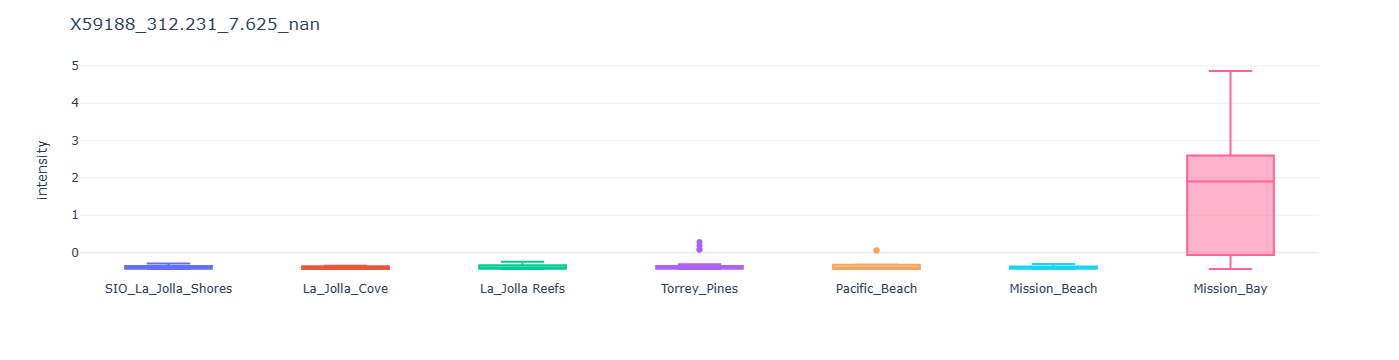

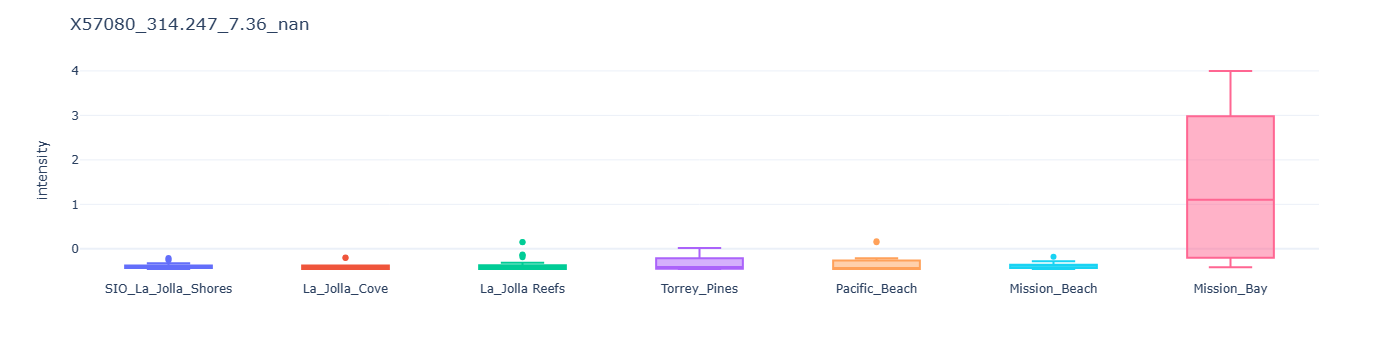

In [426]:
# boxplots with top 4 metabolites from ANOVA
for metabolite in anova.sort_values('p_fdr_bh').iloc[:4, 0]: 
    fig = px.box(cleaned_data_with_md, x=anova_attribute, y=metabolite, color=anova_attribute)
    fig.update_layout(showlegend=False, title=metabolite, xaxis_title="", yaxis_title="intensity", template="plotly_white", width=500)
    display(fig)
    # Save the figure with a filename that includes the metabolite name
    file_name = f"plot_ANOVA_significant_metabolite_{metabolite}.pdf"
    fig.write_image(os.path.join(result_dir, file_name), scale=3)

For the top four metabolites, Mission bay is the area that drives the difference between sampling sites, with much higher levels.

---
## Tukey's post-hoc test
<a name ="tukey"></a>
As mentioned above, Tukey's post hoc test is a common post-hoc test after a 1-way anova. It also assumes the data to be normally distributed and homoscedastic (having same variances). Once we know that there is a significant difference among different sampling sites, we can use tukey-test to calculate, which features show statistically significant differences between 2 sampling sites.

### <font color ='darkblue'> Step 59: Perform Tukey HSD for a Significant Feature </font>

In [425]:
pg.pairwise_tukey(data=cleaned_data_with_md, dv = anova_significant_metabolites[0], between=anova_attribute)

A                    B   mean(A)   mean(B)      diff  \
0        La_Jolla Reefs        La_Jolla_Cove -0.390058 -0.405410  0.015352   
1        La_Jolla Reefs          Mission_Bay -0.390058  1.515913 -1.905971   
2        La_Jolla Reefs        Mission_Beach -0.390058 -0.404035  0.013978   
3        La_Jolla Reefs        Pacific_Beach -0.390058 -0.326873 -0.063185   
4        La_Jolla Reefs  SIO_La_Jolla_Shores -0.390058 -0.403428  0.013371   
5        La_Jolla Reefs         Torrey_Pines -0.390058 -0.358522 -0.031536   
6         La_Jolla_Cove          Mission_Bay -0.405410  1.515913 -1.921323   
7         La_Jolla_Cove        Mission_Beach -0.405410 -0.404035 -0.001374   
8         La_Jolla_Cove        Pacific_Beach -0.405410 -0.326873 -0.078537   
9         La_Jolla_Cove  SIO_La_Jolla_Shores -0.405410 -0.403428 -0.001981   
10        La_Jolla_Cove         Torrey_Pines -0.405410 -0.358522 -0.046888   
11          Mission_Bay        Mission_Beach  1.515913 -0.404035  1.919949   
12          Mission_Bay        Pacific_Beach  1.515913 -0.326873  1.842786   
13          Mission_Bay  SIO_La_Jolla_Shores  1.515913 -0.403428  1.919342   
14          Mission_Bay         Torrey_Pines  1.515913 -0.358522  1.874436   
15        Mission_Beach        Pacific_Beach -0.404035 -0.326873 -0.077162   
16        Mission_Beach  SIO_La_Jolla_Shores -0.404035 -0.403428 -0.000607   
17        Mission_Beach         Torrey_Pines -0.404035 -0.358522 -0.045513   
18        Pacific_Beach  SIO_La_Jolla_Shores -0.326873 -0.403428  0.076556   
19        Pacific_Beach         Torrey_Pines -0.326873 -0.358522  0.031649   
20  SIO_La_Jolla_Shores         Torrey_Pines -0.403428 -0.358522 -0.044906   

          se          T       p-tukey    hedges  
0   0.221664   0.069258  1.000000e+00  0.274997  
1   0.156740 -12.160098  7.482903e-14 -1.823771  
2   0.191966   0.072813  1.000000e+00  0.258596  
3   0.221664  -0.285049  9.999551e-01 -0.601657  
4   0.191966   0.069651  1.000000e+00  0.241725  
5   0.146617  -0.215089  9.999915e-01 -0.241482  
6   0.221664  -8.667746  1.393330e-13 -1.482917  
7   0.247827  -0.005546  1.000000e+00 -0.035935  
8   0.271481  -0.289290  9.999510e-01 -0.575418  
9   0.247827  -0.007995  1.000000e+00 -0.047695  
10  0.214625  -0.218463  9.999907e-01 -0.313472  
11  0.191966  10.001491  7.494005e-14  1.578488  
12  0.221664   8.313439  6.293854e-13  1.418960  
13  0.191966   9.998330  7.494005e-14  1.577916  
14  0.146617  12.784603  7.482903e-14  1.929890  
15  0.247827  -0.311356  9.999245e-01 -0.635406  
16  0.221664  -0.002738  1.000000e+00 -0.014809  
17  0.183794  -0.247632  9.999804e-01 -0.318916  
18  0.247827   0.308907  9.999280e-01  0.624862  
19  0.214625   0.147463  9.999991e-01  0.187131  
20  0.183794  -0.244330  9.999819e-01 -0.313806

The Tukey test gives a Pandas dataframe as an output with the following parameters:  
A: Name of first measurement  
B: Name of second measurement  
mean(A): Mean of first measurement  
mean(B): Mean of second measurement  
diff: Mean difference (= mean(A) - mean(B))  
se: Standard error  
T: T-statistic value  
p-tukey: Tukey-HSD corrected p-values  
hedges: Hedges effect size (or any effect size defined in effsize)

Here, every possible pair-wise group difference is explored. From ANOVA results, since Mission Bay seemed to differ from other sampling sites for the four most significant metabolites, we could specifically look at the results from comparison between Mission Bay and another sampling site.

### <font color ='darkblue'> Step 60: Perform Tukey HSD for all Significant Features </font>

In the code below, we look at the differences between <b> Mission Bay and La Jolla Reefs</b>. We take the anova models that shows significant difference among samplig sites and perform tukey test on only those models.

In [439]:
def tukey_post_hoc_test(df, anova_attribute, contrasts, metabolites):
    
    # Ensure metabolites is a list
    metabolites = [metabolites] if isinstance(metabolites, str) else metabolites

    results = []
    for metabolite in metabolites:
        for contrast in contrasts:
            filtered_df = df[df[anova_attribute].isin(contrast)][[metabolite, anova_attribute]]
            pairwise_tukey = pg.pairwise_tukey(filtered_df, dv=metabolite, between=anova_attribute)
            
            # Getting the order from Tukey result
            group_A = pairwise_tukey['A'].iloc[0]
            group_B = pairwise_tukey['B'].iloc[0]

            diff_value = pairwise_tukey['diff'].iloc[0]
            p_tukey_value = pairwise_tukey['p-tukey'].iloc[0]
            
            results.append([f'{group_A}-{group_B}', metabolite, int(metabolite.split('_')[0].replace('X', '')), diff_value, p_tukey_value])
    
    tukey = pd.DataFrame(results, columns=['contrast', 'stats_metabolite', 'stats_ID', 'stats_diff', 'stats_p'])
    
    # add Benjamini-Hochberg corrected p-values
    tukey['stats_p_bh'] = pg.multicomp(tukey['stats_p'], method='fdr_bh')[1] 
    
    # add significance
    tukey['stats_significant'] = tukey['stats_p_bh'] < 0.05  
    
    # sort by p-value
    tukey.sort_values('stats_p_bh', inplace=True)
    
    return tukey


This function performs a Tukey's post-hoc test to determine significant differences between group means for specified metabolites. The test is performed for each combination of contrasts and metabolites provided.

<b>Input Parameters:</b>  

- `df` (`pandas.DataFrame`): The dataframe containing the feature intensity information and metadata attributes.
- `anova_attribute` (`str`): The metadata attribute you used for ANOVA test. This contains the group information used in the Tukey's test.
- `contrasts` (`list` of `tuple`): A list of tuples where each tuple contains two group names to be compared in the Tukey's test.
- `metabolites` (`list` or `str`): List of metabolite feature names (or a single metabolite name as a string) for which the Tukey's test needs to be performed. If a single string is provided, the function will convert it to a list.

<b>Returns:</b> Pandas Dataframe containing seven columns:
 - Contrast name in the format as in the Tukey output `group1-group2`.
 - Metabolite name (`stats_metabolite`)
 - Extracted ID from the metabolite name (`stats_ID`).
 - Difference in means between the two groups for the metabolite (`stats-diff`).
 - p-value for the significance of the difference (`stats-p`).
 - BH corrected p-value (`stats_p_bh`)
 - Significance based on the BH corrected p-value (`stats_significant`)

In [417]:
for value in cleaned_data_with_md[anova_attribute].unique():
    print(value)

SIO_La_Jolla_Shores
La_Jolla_Cove
La_Jolla Reefs
Torrey_Pines
Pacific_Beach
Mission_Beach
Mission_Bay


<font color="red" size="4">The cell above shows the different groups within the `anova_attribute`. For the subsequent Tukey test, please specify the two groups you'd like to compare by entering their names in the next cell.</font>

In [418]:
group1 = "Mission_Bay"
group2 = "La_Jolla Reefs"

In [440]:
contrasts = [(group1, group2)]

# Applying the tukey_post_hoc_test function
tukey = tukey_post_hoc_test(df = cleaned_data_with_md, 
                            anova_attribute = anova_attribute, 
                            contrasts = contrasts,
                            metabolites= anova_significant_metabolites)
tukey.head()

contrast          stats_metabolite  stats_ID  \
0   La_Jolla Reefs-Mission_Bay  X59188_312.231_7.625_nan     59188   
24  La_Jolla Reefs-Mission_Bay  X60583_506.326_7.811_nan     60583   
1   La_Jolla Reefs-Mission_Bay  X33200_260.196_4.886_nan     33200   
2   La_Jolla Reefs-Mission_Bay   X57080_314.247_7.36_nan     57080   
15  La_Jolla Reefs-Mission_Bay  X36504_214.191_5.227_nan     36504   

    stats_diff       stats_p    stats_p_bh  stats_significant  
0    -1.905971  3.887168e-11  1.463908e-07               True  
24   -1.670331  2.248162e-10  3.413511e-07               True  
1    -1.834684  2.719207e-10  3.413511e-07               True  
2    -1.781706  3.212070e-09  3.024164e-06               True  
15   -1.722793  4.710073e-09  3.547627e-06               True

In [554]:
tukey.to_csv(os.path.join(result_dir, f"Tukey_posthoc_test_{group1}_{group2}.csv"), index=False)

### <font color ='darkblue'> Step 61: Count Significant Features </font>

In [465]:
print("Total no.of features on which ANOVA test was performed:", len(tukey))
print("No.of features that showed significant difference:", len(tukey[tukey["stats_significant"]==True]))
print("No.of features that did not show significant difference:", len(tukey[tukey["stats_significant"]==False]))

Total no.of features on which ANOVA test was performed: 3766
No.of features that showed significant difference: 2815
No.of features that did not show significant difference: 951


### <font color ='darkblue'> Step 62: Visualize Results with a Volcano Plot </font>

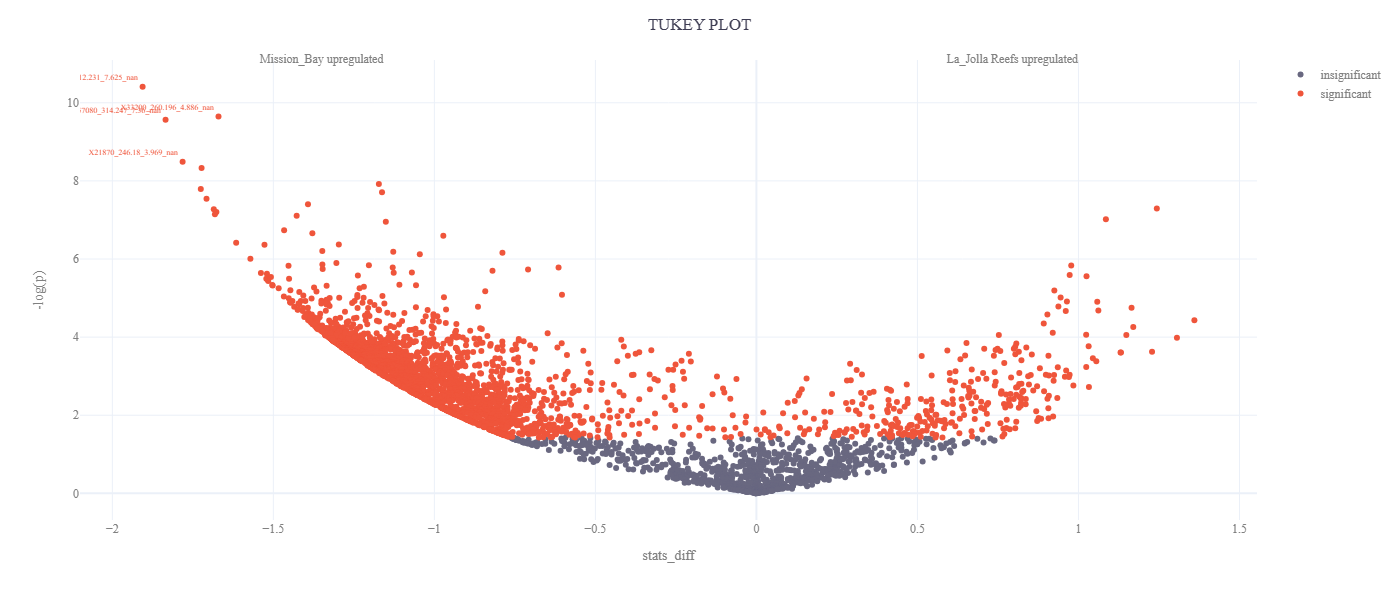

In [464]:
fig = px.scatter(template='plotly_white', width=1000, height=600)

# plot insignificant values
fig.add_trace(go.Scatter(x=tukey[tukey['stats_significant'] == False]['stats_diff'],
                         y=tukey[tukey['stats_significant'] == False]['stats_p'].apply(lambda x: -np.log10(x)),
                         mode='markers', marker_color='#696880', name='insignificant'))

# plot significant values
fig.add_trace(go.Scatter(x=tukey[tukey['stats_significant']]['stats_diff'],
                         y=tukey[tukey['stats_significant']]['stats_p'].apply(lambda x: -np.log10(x)),
                         mode='markers+text', text=anova['metabolite'].iloc[:4], textposition='top left',
                         textfont=dict(color='#ef553b', size=8), marker_color='#ef553b', name='significant'))

# Grabbing the groups from the first contrast
group_A = tukey['contrast'].str.split('-').str[0].iloc[0]
group_B = tukey['contrast'].str.split('-').str[1].iloc[0]

# Add annotations to the figure to indicate upregulated and downregulated groups
fig.add_annotation(
    x=0.85, # Position on x-axis (between 0 and 1)
    y=1.02, # Position on y-axis (between 0 and 1)
    xref="paper",
    yref="paper",
    text=f"{group_A} upregulated",
    showarrow=False
)

fig.add_annotation(
    x=0.15, # Position on x-axis (between 0 and 1)
    y=1.02, # Position on y-axis (between 0 and 1)
    xref="paper",
    yref="paper",
    text=f"{group_B} upregulated",
    showarrow=False
)

fig.update_layout(font={"color":"grey", "size":12, "family":"Sans"},
                  title={"text":"TUKEY PLOT", 'x':0.5, "font_color":"#3E3D53"},
                  xaxis_title="stats_diff", yaxis_title="-log(p)")

# save image as pdf
fig.write_image(os.path.join(result_dir, "TukeyHSD.pdf"), scale=3)

display(fig)

Also visualizing the boxplots of the top 2 significant metabolites on the **right tail of the volcano plot**:

In [468]:
rightside_top_metabolites = tukey[tukey['stats_significant']].sort_values('stats_diff', ascending=False)['stats_metabolite'].iloc[:2]

for stats_metabolite in rightside_top_metabolites: 
    fig = px.box(cleaned_data_with_md, x=anova_attribute, y=stats_metabolite, color=anova_attribute)
    fig.update_layout(showlegend=False, title=stats_metabolite, xaxis_title="", yaxis_title="intensity", template="plotly_white", width=500)
    fig.show()

Also visualizing the boxplots of the top 2 significant metabolites on the left tail of the volcano plot:

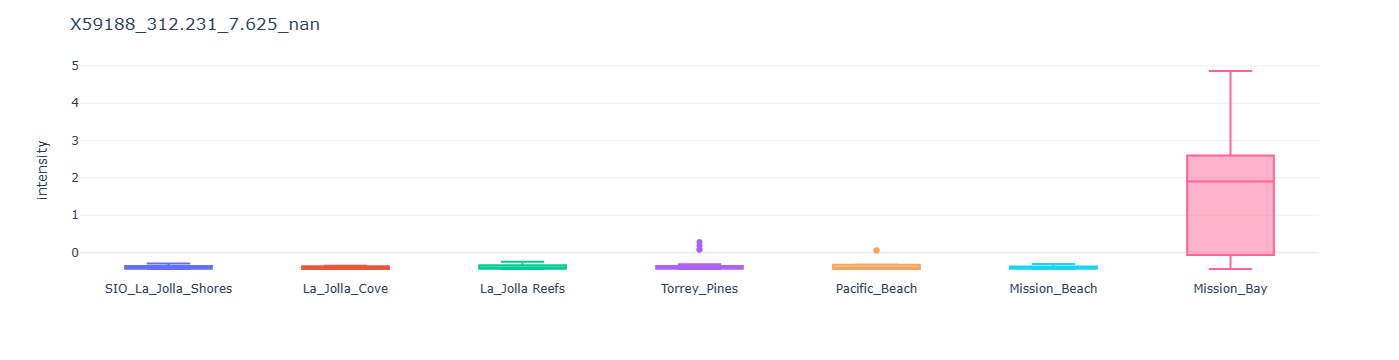

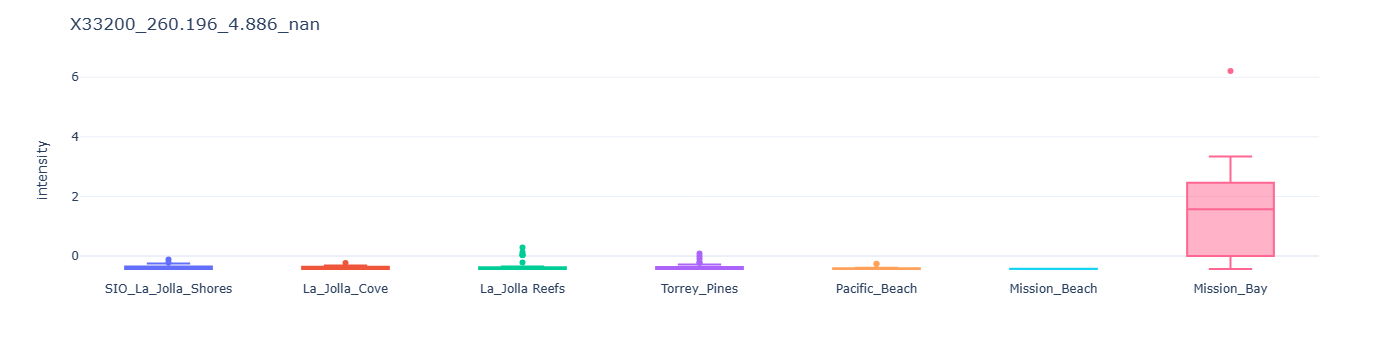

In [467]:
leftside_top_metabolites = tukey[tukey['stats_significant']].sort_values('stats_diff')['stats_metabolite'].iloc[:2]

for stats_metabolite in leftside_top_metabolites: 
    fig = px.box(cleaned_data_with_md, x=anova_attribute, y=stats_metabolite, color=anova_attribute)
    fig.update_layout(showlegend=False, title=stats_metabolite, xaxis_title="", yaxis_title="intensity", template="plotly_white", width=500)
    fig.show()

---
## T-test
<a name = "t_test"></a>

A T-test is commonly used when one has to compare between only two groups. Here, null hypothesis H0 states no difference between the mean of 2 groups. Similar to the F-statistic used by ANOVA, T-tests use T-statistic.


$$\text{T-statistic} = \frac{\text{Mean}_{\text{group}} - \text{Mean}_{\text{population}}}{\text{SD}_{\text{group}} / \sqrt{\text{group size}}}$$


In our dataset, a heavy rainfall in January 2018 could have influenced the metabolome. We will investigate the effect of the rainfall using t-tests. The 2 conditions will be 'Jan-2018' or 'not Jan-2018'

### <font color ='darkblue'> Step 63: Select Attribute for T-test Analysis </font>

In [476]:
for i in cleaned_data_with_md.iloc[:, 1:].filter(regex='^(?!X)').columns:
    print(i)

ATTRIBUTE_Batch
ATTRIBUTE_Month
ATTRIBUTE_Year
ATTRIBUTE_Sample_Location
ATTRIBUTE_Replicate
ATTRIBUTE_Spot
ATTRIBUTE_Latitude
ATTRIBUTE_Longitude
ATTRIBUTE_Sample_Area
ATTRIBUTE_Spot_Name
ATTRIBUTE_time_run
ATTRIBUTE_Injection_order


<font color = "red" size = 4>For your own dataset, the next step may not be necessary if you already have an attribute with just two groups that you wish to investigate. If your data requires different handling, please modify the code in the following cell to suit your needs. </font>

In [480]:
ttest_attribute = 'ATTRIBUTE_Month'
target_group = 'Jan'

Here, the 2 conditions for T-test will be 'Jan-2018' or 'not Jan-2018'

### <font color ='darkblue'> Step 64: Perform T-Test </font>

In [491]:
# Defining a function to generate T-tests:
def gen_ttest_data(df, columns, ttest_attribute, target_group):
    ttest = []
    for col in columns:
        group1 = df[col][df[ttest_attribute]==target_group]
        group2 = df[col][df[ttest_attribute]!=target_group]
        result = pg.ttest(group1, group2)
        result['Metabolite'] = col

        ttest.append(result)

    ttest = pd.concat(ttest).set_index('Metabolite')

    ttest.insert(8, 'p-bh', pg.multicomp(ttest['p-val'], method='fdr_bh')[1])
    # add significance
    ttest.insert(9, 'Significance', ttest['p-bh'] < 0.05)
    ttest.sort_values('p-bh', inplace=True)

    return ttest

The above function perform t-test for all metabolites in the given feature table.

The input arguments:
- `df`: The dataframe which contains the feature intensity information and metadata attributes
- `columns`: A string of all feature names for which t-test needs to be performed
- `ttest_attribute`: The metadata attribute which contains the group information to perform ttest
- ` target_group`: In case of multiple groups in the attribute, it will converted to binary information such as 'target_group' vs others

Returns:  
A pandas dataframe with columns:  
- 'Metabolite' - Name of the metabolite
- 'T': T-value
- 'dof': degrees of freedom
- 'alternative': alternative of the test
- 'p-val': p-value
- 'CI95%': confidence intervals of the difference in means
- 'cohen-d': Cohen d effect size
- 'BF10': Bayes Factor of the alternative hypothesis
- 'power': achieved power of the test ( = 1 - type II error)
- 'p-bh' : BH-corrected P values
- 'Significance': Significance value based on BH-corrected P values

In [552]:
ttest = gen_ttest_data(cleaned_data_with_md, uni_data.columns, ttest_attribute, target_group)
ttest.head(5)

ttest.to_csv(os.path.join(result_dir, f"ttest_results_{ttest_attribute}_target_group_{target_group}.csv"))

### <font color ='darkblue'> Step 65: Plot T-Test Results </font>

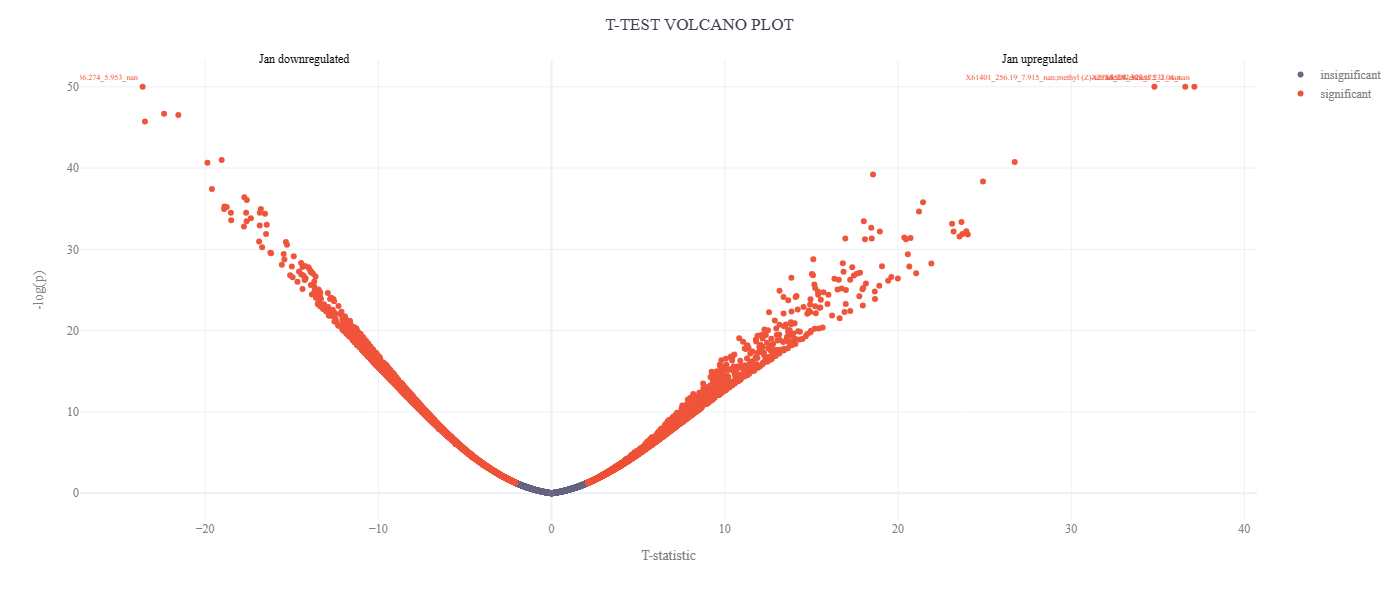

In [498]:
# To avoid taking -log10(0)
ttest['log_p'] = ttest['p-bh'].apply(lambda x: -np.log10(x + 1e-50))

fig = px.scatter(template='plotly_white', width=1000, height=600)

# Plot insignificant values
fig.add_trace(go.Scatter(x=ttest[ttest['Significance'] == False]['T'],
                         y=ttest[ttest['Significance'] == False]['log_p'],
                         mode='markers', marker_color='#696880', name='insignificant'))

# Plot significant values
fig.add_trace(go.Scatter(x=ttest[ttest['Significance']]['T'],
                         y=ttest[ttest['Significance']]['log_p'],
                         mode='markers+text', text=ttest.index[:4], textposition='top left',
                         textfont=dict(color='#ef553b', size=8), marker_color='#ef553b', name='significant'))

fig.update_layout(font={"color":"grey", "size":12, "family":"Sans"},
                  title={"text":"T-TEST VOLCANO PLOT", 'x':0.5, "font_color":"#3E3D53"},
                  xaxis_title="T-statistic", yaxis_title="-log(p)")

# Adding annotations
fig.add_annotation(
    x=0.85,  # Position on x-axis (between 0 and 1)
    y=1.02,  # Position on y-axis (between 0 and 1)
    xref="paper",
    yref="paper",
    text=f"{target_group} upregulated",
    showarrow=False,
    font=dict(size=12, color="black")
)

fig.add_annotation(
    x=0.15,  # Position on x-axis (between 0 and 1)
    y=1.02,  # Position on y-axis (between 0 and 1)
    xref="paper",
    yref="paper",
    text=f"{target_group} downregulated",
    showarrow=False,
    font=dict(size=12, color="black")
)

# save image as pdf
fig.write_image(os.path.join(result_dir, "T-Test_Volcano_Plot.pdf"), scale=3)

display(fig)


In addition to that, visualizing **the top 2 significant metabolites from the right tail of the volcano plot:**

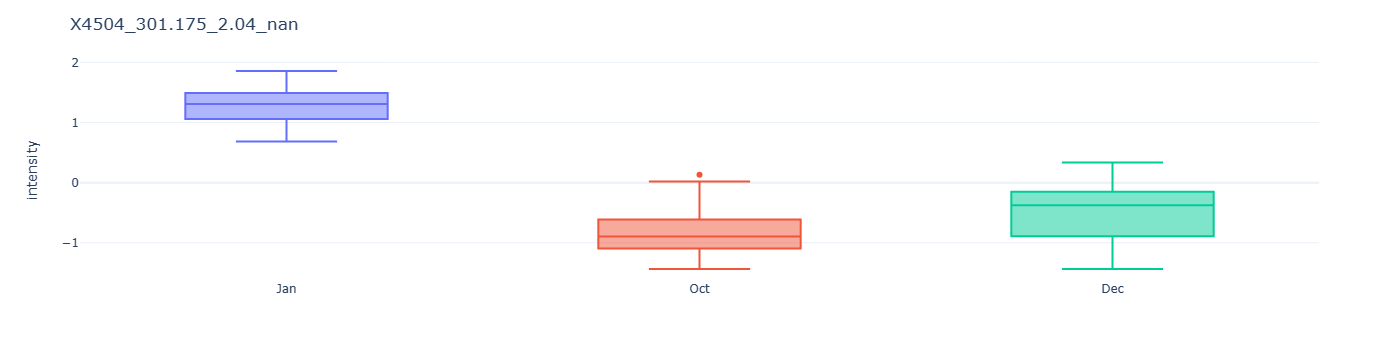

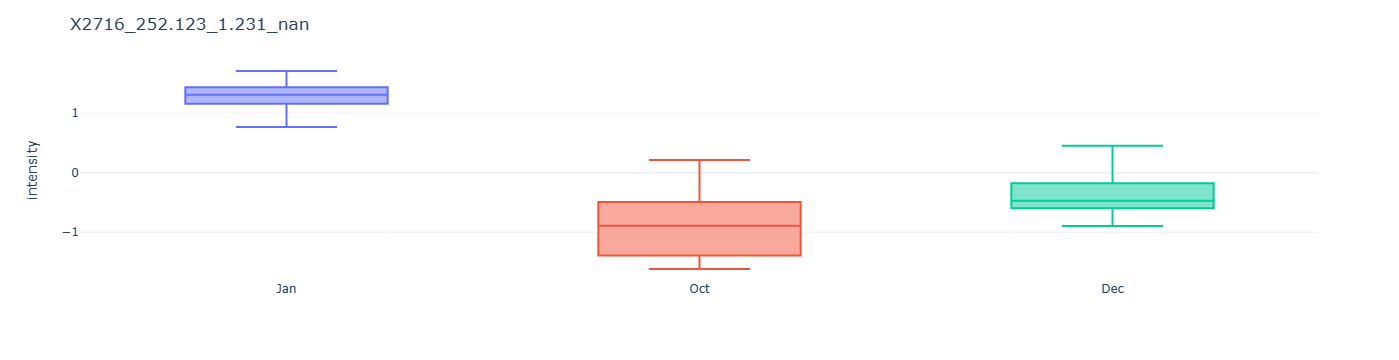

In [496]:
rightside_top_metabolites_ttest = ttest[ttest['Significance']].sort_values('T', ascending=False).index[:2]

for metabolite in rightside_top_metabolites_ttest: 
    fig = px.box(cleaned_data_with_md, x=ttest_attribute, y=metabolite, color=ttest_attribute)
    fig.update_layout(showlegend=False, title=metabolite, xaxis_title="", yaxis_title="intensity", template="plotly_white", width=500)
    fig.show()

In addition to that, visualizing **the top 2 significant metabolites from the left tail of the volcano plot:**

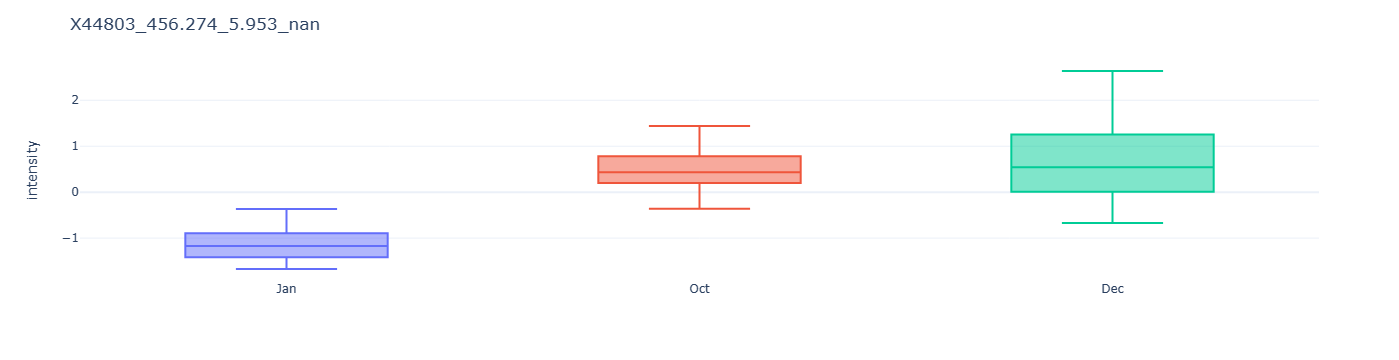

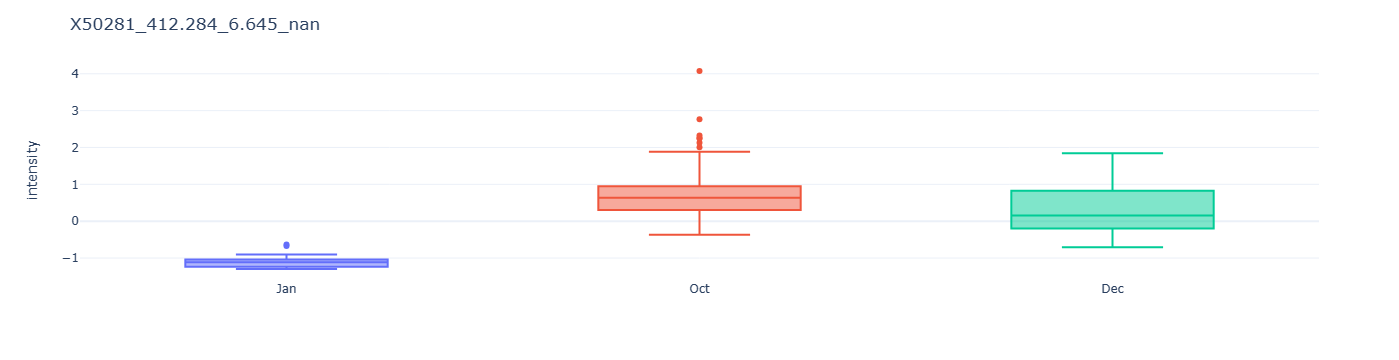

In [497]:
leftside_top_metabolites_ttest = ttest[ttest['Significance']].sort_values('T').index[:2]

for metabolite in leftside_top_metabolites_ttest: 
    fig = px.box(cleaned_data_with_md, x=ttest_attribute, y=metabolite, color=ttest_attribute)
    fig.update_layout(showlegend=False, title=metabolite, xaxis_title="", yaxis_title="intensity", template="plotly_white", width=500)
    fig.show()

---
## Kruskal-Wallis Test
<a name="kr_wallis"></a>

Kruskal-Wallis Test is a non-parametric version of ANOVA. Here, the test does not assume normality of the data. The median of multiple groups are compared to see if they are statistically different from one another. The null hypothesis H0 states no significant difference among different groups. Based on the p value, we decide whether to reject H0 or not. When H0 is rejected, the alternate hypothesis H1 states that atleast one group is statistically different from the others.
<a href="https://statsandr.com/blog/kruskal-wallis-test-nonparametric-version-anova/#introduction">Read more about Kruskal-Wallis test</a>

### <font color ='darkblue'> Step 66: Perform Kruskal-Wallis Test on the first feature </font>

In [499]:
InsideLevels(cleaned_data_with_md.iloc[:, 1:].filter(regex='^(?!X)'))

ATTRIBUTES  \
1             ATTRIBUTE_Batch   
2             ATTRIBUTE_Month   
3              ATTRIBUTE_Year   
4   ATTRIBUTE_Sample_Location   
5         ATTRIBUTE_Replicate   
6              ATTRIBUTE_Spot   
7          ATTRIBUTE_Latitude   
8         ATTRIBUTE_Longitude   
9       ATTRIBUTE_Sample_Area   
10        ATTRIBUTE_Spot_Name   
11         ATTRIBUTE_time_run   
12  ATTRIBUTE_Injection_order   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           LEVELS  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

<font color="red" size="4">Based on the summary table provided above, please input the name of the attribute you wish to use for the ANOVA analysis in the cell below.</font> Here, we tried to perfom Kruskal-Wallis test across different sample areas similar to its parametric counterpart, ANOVA.

In [514]:
# select an attribute to perform Kruskal Wallis
kruskal_attribute = 'ATTRIBUTE_Sample_Area'

In [507]:
print(uni_data.columns[0])
pg.kruskal(cleaned_data_with_md, uni_data.columns[0], kruskal_attribute, detailed=True)

X2_161.096_0.235_nan;Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one


Source  ddof1         H     p-unc
Kruskal  ATTRIBUTE_Sample_Area      6  7.483531  0.278433

The test returns a pandas dataframe with the follwoing columns:  
- 'H': The Kruskal-Wallis H statistic, corrected for ties
- 'p-unc': Uncorrected p-value
- 'ddof1': degrees of freedom

### <font color ='darkblue'> Step 67: Perform Kruskal-Wallis Test on all features </font>

In [533]:
## defining a function to perform kruskal-wallis test all features:

def gen_kruskal_data(df, columns, groups_col):
    results = []
    
    for col in columns:
        result = pg.kruskal(data=df, dv=col, between=groups_col, detailed=True).set_index('Source')
        p = result.loc[groups_col, 'p-unc']
        H = result.loc[groups_col, 'H']
        dof = result.loc[groups_col, 'ddof1']
 
        results.append([col, int(col.split('_')[0].replace('X', '')), p, H, dof])
    
    kruskal_columns = ['metabolite', 'stats_ID', 'p', 'H', 'dof']
    kruskal = pd.DataFrame(results, columns=kruskal_columns)
        
    # add Benjamini-Hochberg corrected p-values
    kruskal['stats_p_bh'] = pg.multicomp(kruskal['p'], method='fdr_bh')[1] 
        
    # add significance
    kruskal['stats_significant'] = kruskal['stats_p_bh'] < 0.05  
        
    # sort by p-value
    kruskal.sort_values('stats_p_bh', inplace=True)
        
    return kruskal

In [556]:
kruskal = gen_kruskal_data(cleaned_data_with_md, uni_data.columns, kruskal_attribute)
kruskal.head()

kruskal.to_csv(os.path.join(result_dir, f"kruskal_results_{kruskal_attribute}.csv"))

### <font color ='darkblue'> Step 68: Filter Significant Features </font>

In [535]:
print("Total no.of features on which Kruskal-Wallis test was performed:", len(kruskal))
print("No.of features that showed significant difference:", len(kruskal[kruskal["stats_significant"]==True]))
print("No.of features that did not show significant difference:", len(kruskal[kruskal["stats_significant"]==False]))

Total no.of features on which Kruskal-Wallis test was performed: 9092
No.of features that showed significant difference: 1278
No.of features that did not show significant difference: 7814


In [536]:
# collecting the significant features in an array
kruskal_significant_metabolites = kruskal[kruskal["stats_significant"]==True]["metabolite"].to_numpy()
kruskal_significant_metabolites

array(['X91372_906.258_12.697_nan;(3S,4R)-7-hydroxy-3-[(3S,4R)-7-hydroxy-4-(4-hydroxyphenyl)-2-oxo-5-[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy-3,4-dihydrochromen-3-yl]-4-(4-hydroxyphenyl)-5-[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy-3,4-dihydrochromen-2-one',
       'X90743_908.258_12.555_nan;[3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl] 9-(hydroxymethyl)-2,2,6a,6b,9,12a-hexamethyl-10-[3,4,5-trihydroxy-6-[(3,4,5-trihydroxy-6-methyloxan-2-yl)oxymethyl]oxan-2-yl]oxy-1,3,4,5,6,6a,7,8,8a,10,11,12,13,14b-tetradecahydropicene-4a-carboxylate',
       'X91133_907.259_12.628_nan;THEAFLAVIN DIGALLATE', ...,
       'X88253_700.234_11.593_Contaminant vial septum ThermoFisher C5000-44B',
       'X1325_350.744_0.711_nan', 'X2761_284.206_1.252_nan'], dtype=object)

### <font color ='darkblue'> Step 69: Visualize Kruskal-Wallis Results </font>

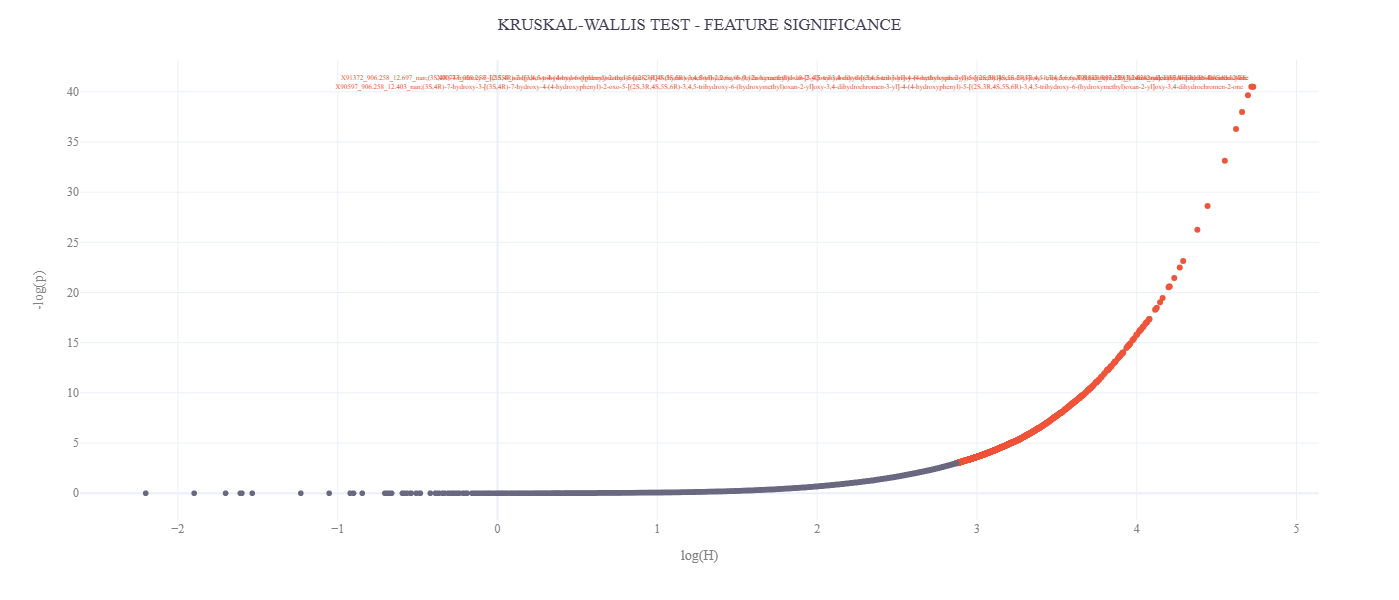

In [528]:
# first plot in significant features
fig = px.scatter(x=kruskal[kruskal['stats_significant'] == False]['H'].apply(np.log),
                y=kruskal[kruskal['stats_significant'] == False]['stats_p_bh'].apply(lambda x: -np.log(x)),
                template='plotly_white', width=600, height=600)
fig.update_traces(marker_color="#696880")

# plot significant features
fig.add_scatter(x=kruskal[kruskal['stats_significant']]['H'].apply(np.log),
                y=kruskal[kruskal['stats_significant']]['stats_p_bh'].apply(lambda x: -np.log(x)),
                mode='markers+text',
                text=kruskal['metabolite'].iloc[:4],
                textposition='top left', textfont=dict(color='#ef553b', size=7), name='significant')

fig.update_layout(font={"color":"grey", "size":12, "family":"Sans"},
                  title={"text":"KRUSKAL-WALLIS TEST - FEATURE SIGNIFICANCE", 'x':0.5, "font_color":"#3E3D53"},
                  xaxis_title="log(H)", yaxis_title="-log(p)", showlegend=False)

# save fig as pdf
fig.write_image(os.path.join(result_dir, "plot_kruskal.pdf"), scale=3) # you can use different file types here e.g. svg, png

fig.show()

### <font color ='darkblue'> Step 70: Visualize Top Significant Metabolites of Kruskal-Wallis Results</font>

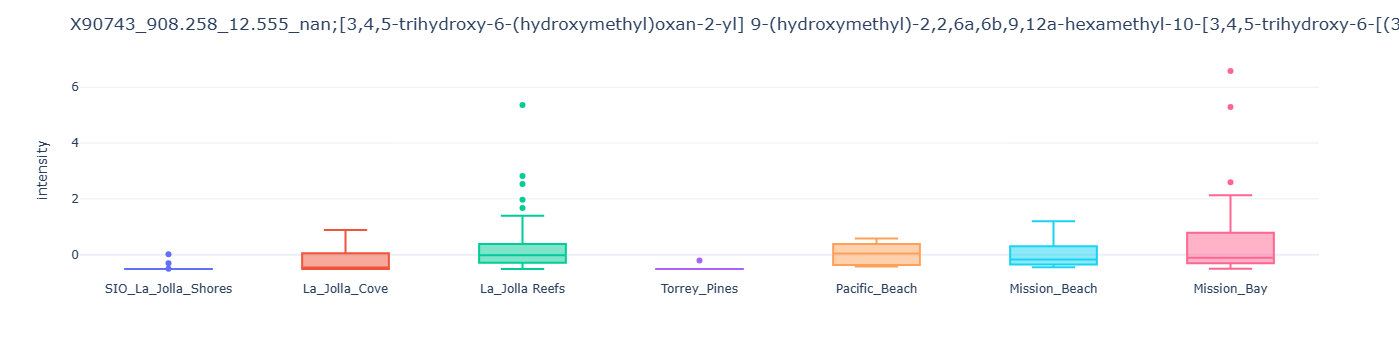

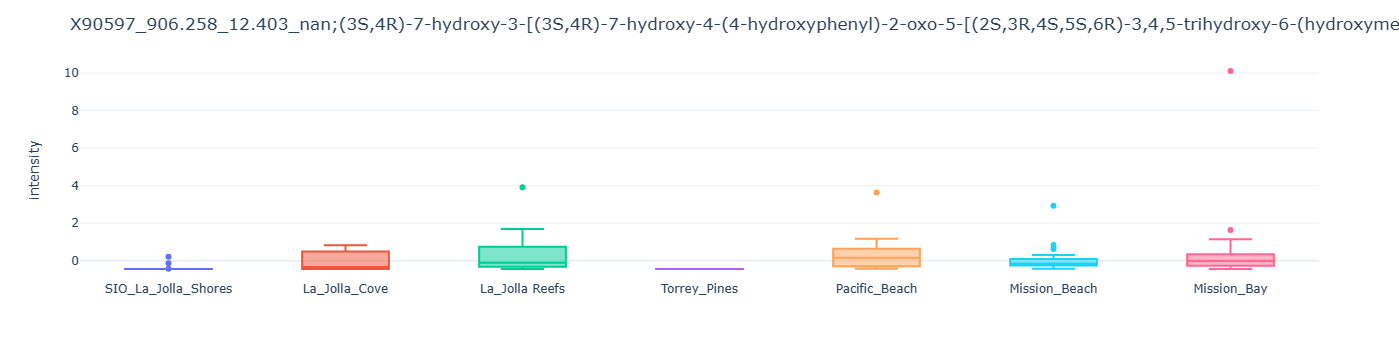

In [538]:
for idx, row in kruskal.sort_values('stats_p_bh').iloc[:4].iterrows():
    metabolite = row['metabolite']
    stats_id = row['stats_ID']
    fig = px.box(cleaned_data_with_md, x=kruskal_attribute, y=metabolite, color=kruskal_attribute)
    fig.update_layout(showlegend=False, title=metabolite, xaxis_title="", yaxis_title="intensity", template="plotly_white", width=500)
    display(fig)
    
    # Save the figure with the stats_ID in the filename
    file_name = f"plot_KruskalWallis_significant_metabolite_{stats_id}.pdf"
    fig.write_image(os.path.join(result_dir, file_name), scale=3)

### <font color ='darkblue'> Step 71: Compare Results from ANOVA and Kruskal-Wallis</font>

In [542]:
# Prefix the Kruskal columns with 'KW_'
kruskal_prefixed = kruskal.add_prefix('KW_')

anova_kruskal_combined = pd.merge(anova, kruskal_prefixed, left_on='metabolite', right_on='KW_metabolite', how='outer')

# drop the duplicate metabolite column after the merge
anova_kruskal_combined = anova_kruskal_combined.drop(columns=['KW_metabolite'])

anova_kruskal_combined.head()

metabolite  \
0  X2_161.096_0.235_nan;Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one   
1                                                                          X4_167.154_0.474_nan   
2                    X11_172.956_0.487_nan;"6-methoxypurine, oxamethane CollisionEnergy:102040"   
3                                                                         X15_289.168_0.501_nan   
4                                                                         X16_291.165_0.501_nan   

          p         F        MS     Significance  KW_stats_ID      KW_p  \
0  0.094279  1.838234  1.797985  Non-significant            2  0.278433   
1  0.567786  0.804353  0.814186  Non-significant            4  0.404952   
2  0.353409  1.118602  1.120397  Non-significant           11  0.261520   
3  0.314193  1.189249  1.188354  Non-significant           15  0.027266   
4  0.319167  1.179930  1.179409  Non-significant           16  0.100155   

        KW_H  KW_dof  KW_stats_p_bh  KW_stats_significant  
0   7.483531       6       0.495689                 False  
1   6.165102       6       0.623129                 False  
2   7.692355       6       0.478225                 False  
3  14.220690       6       0.117560                 False  
4  10.640170       6       0.266766                 False

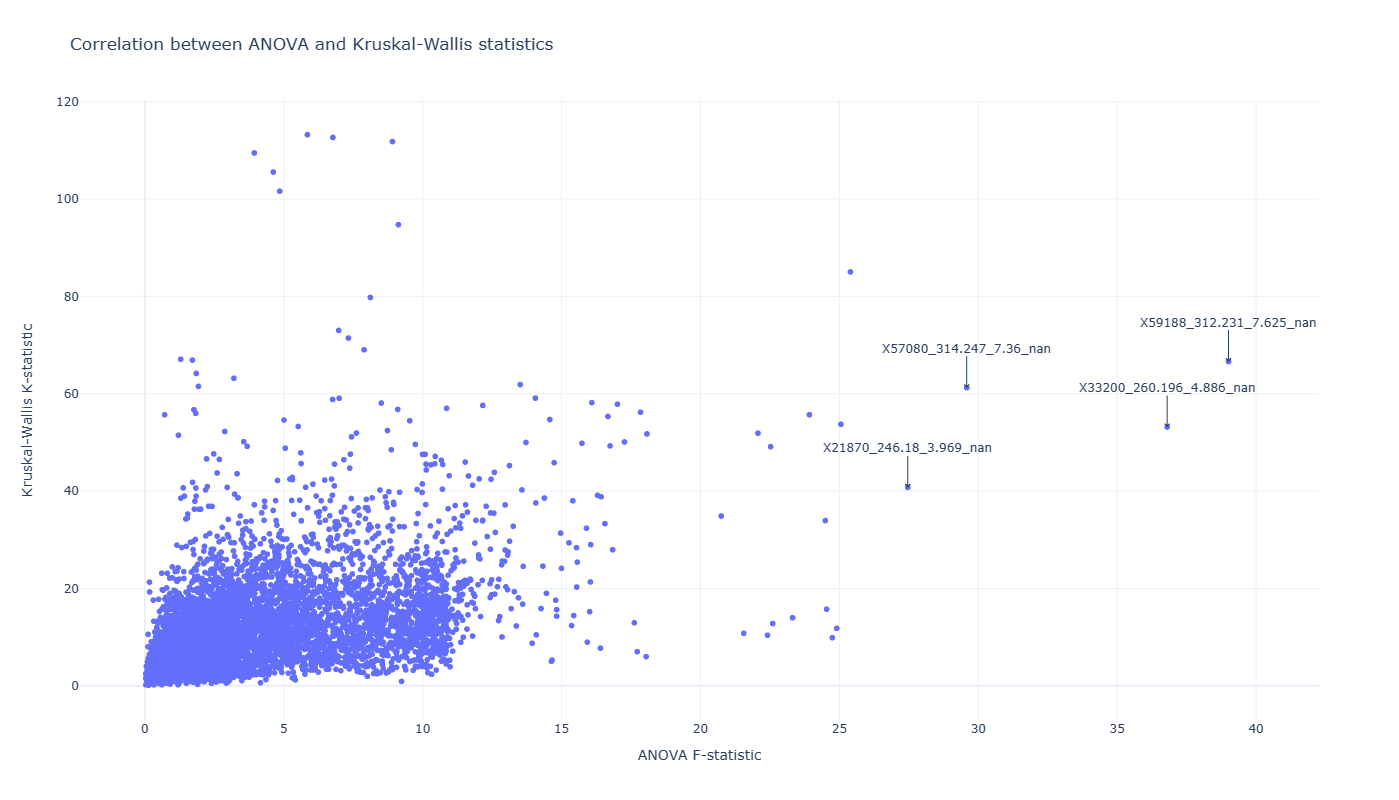

In [549]:
# Sort the data based on 'F' and 'KW_H' and get the top 4 metabolites from each
top_metabolites_anova = anova_kruskal_combined.sort_values(by='F', ascending=False).iloc[:4]

# Creating the correlation plot using Plotly
correlation_plot = px.scatter(
    anova_kruskal_combined, 
    x="F", 
    y="KW_H", 
    labels={"F": "ANOVA F-statistic", "KW_H": "Kruskal-Wallis K-statistic"}, 
    title="Correlation between ANOVA and Kruskal-Wallis statistics",
    template="plotly_white"
)

# Annotate top metabolites from ANOVA
for _, row in top_metabolites_anova.iterrows():
    correlation_plot.add_annotation(
        go.layout.Annotation(
            text=row['metabolite'],
            x=row['F'],
            y=row['KW_H'],
            showarrow=True,
            arrowhead=4,
            ax=0,
            ay=-40
        )
    )

# Setting the plot size
correlation_plot.update_layout(width=1000, height=800)

correlation_plot.show()

file_name = f"correlation_ANOVA_kruskal-Wallis_{kruskal_attribute}.svg"
correlation_plot.write_image(os.path.join(result_dir, file_name))

A higher score for a particular feature in both axes indicates that both tests, ANOVA and Kruskal-Wallis, rejected the null-hypothesis. Thus those features are significantly different among different groups.

In [551]:
# Compute the Spearman correlation
correlation, p_value = spearmanr(anova_kruskal_combined["F"], anova_kruskal_combined["KW_H"])

print(f"Spearman correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4e}")

Spearman correlation: 0.6383
P-value: 0.0000e+00


---
## Dunn's post hoc test
<a name ="dunn"></a>

If Kruskal_Wallis test shows there is a significant difference among groups, then we can perform post-hoc test. The most common post-hoc test for Kruskal-Wallis is "Dunn Test" where one can perform multiple pairwise comparison to know exactly which groups are significantly different.
Here, in our example, we use Dunn test to calculate, which features show statistically significant differences between individual sampling sites.

### <font color ='darkblue'> Step 72: Perform Dunn Test for a Significant Feature </font>

In [ ]:
pg.pairwise_tukey(data=cleaned_data_with_md, dv = anova_significant_metabolites[0], between=anova_attribute)

In [576]:
dunn_test_one_feature = sp.posthoc_dunn(a=cleaned_data_with_md, val_col  = kruskal_significant_metabolites[0], group_col =kruskal_attribute, p_adjust='fdr_bh', sort=True)
dunn_test_one_feature

La_Jolla Reefs  La_Jolla_Cove   Mission_Bay  \
La_Jolla Reefs         1.000000e+00       0.062882  7.358203e-01   
La_Jolla_Cove          6.288240e-02       1.000000  1.144761e-01   
Mission_Bay            7.358203e-01       0.114476  1.000000e+00   
Mission_Beach          4.194062e-01       0.350144  6.429004e-01   
Pacific_Beach          7.524000e-01       0.234279  9.540869e-01   
SIO_La_Jolla_Shores    6.980727e-07       0.062882  3.695907e-06   
Torrey_Pines           7.773518e-16       0.000952  1.804138e-14   

                     Mission_Beach  Pacific_Beach  SIO_La_Jolla_Shores  \
La_Jolla Reefs        4.194062e-01   7.524000e-01         6.980727e-07   
La_Jolla_Cove         3.501442e-01   2.342792e-01         6.288240e-02   
Mission_Bay           6.429004e-01   9.540869e-01         3.695907e-06   
Mission_Beach         1.000000e+00   7.358203e-01         6.356242e-04   
Pacific_Beach         7.358203e-01   1.000000e+00         5.761750e-04   
SIO_La_Jolla_Shores   6.356242e-04   5.761750e-04         1.000000e+00   
Torrey_Pines          9.496747e-08   3.946330e-07         3.158202e-01   

                     Torrey_Pines  
La_Jolla Reefs       7.773518e-16  
La_Jolla_Cove        9.515232e-04  
Mission_Bay          1.804138e-14  
Mission_Beach        9.496747e-08  
Pacific_Beach        3.946330e-07  
SIO_La_Jolla_Shores  3.158202e-01  
Torrey_Pines         1.000000e+00

In [577]:
# Filter the results to show only significant p-values (e.g., < 0.05)
significant_pvals_df = dunn_test_one_feature.where(dunn_test_one_feature < 0.05)
significant_pvals_df

La_Jolla Reefs  La_Jolla_Cove   Mission_Bay  \
La_Jolla Reefs                  NaN            NaN           NaN   
La_Jolla_Cove                   NaN            NaN           NaN   
Mission_Bay                     NaN            NaN           NaN   
Mission_Beach                   NaN            NaN           NaN   
Pacific_Beach                   NaN            NaN           NaN   
SIO_La_Jolla_Shores    6.980727e-07            NaN  3.695907e-06   
Torrey_Pines           7.773518e-16       0.000952  1.804138e-14   

                     Mission_Beach  Pacific_Beach  SIO_La_Jolla_Shores  \
La_Jolla Reefs                 NaN            NaN         6.980727e-07   
La_Jolla_Cove                  NaN            NaN                  NaN   
Mission_Bay                    NaN            NaN         3.695907e-06   
Mission_Beach                  NaN            NaN         6.356242e-04   
Pacific_Beach                  NaN            NaN         5.761750e-04   
SIO_La_Jolla_Shores   6.356242e-04   5.761750e-04                  NaN   
Torrey_Pines          9.496747e-08   3.946330e-07                  NaN   

                     Torrey_Pines  
La_Jolla Reefs       7.773518e-16  
La_Jolla_Cove        9.515232e-04  
Mission_Bay          1.804138e-14  
Mission_Beach        9.496747e-08  
Pacific_Beach        3.946330e-07  
SIO_La_Jolla_Shores           NaN  
Torrey_Pines                  NaN

### <font color ='darkblue'> Step 73: Perform Dunn Test for all Significant Features </font>

In [578]:
def dunn_post_hoc_test(df, kruskal_attribute, contrasts, metabolites):
    
    # Ensure metabolites is a list
    metabolites = [metabolites] if isinstance(metabolites, str) else metabolites

    results = []
    for metabolite in metabolites:
        for contrast in contrasts:
            filtered_df = df[df[kruskal_attribute].isin(contrast)][[metabolite, kruskal_attribute]]
            
            # Conduct Dunn's posthoc test
            dunn_result = sp.posthoc_dunn(a=filtered_df, val_col=metabolite, group_col=kruskal_attribute, p_adjust='fdr_bh', sort=True)
            p_value = dunn_result.loc[contrast[0], contrast[1]]
            
            # Calculate rank sum differences
            ranks = stats.rankdata(filtered_df[metabolite])
            rank_sum_A = sum(ranks[filtered_df[kruskal_attribute] == contrast[0]])
            rank_sum_B = sum(ranks[filtered_df[kruskal_attribute] == contrast[1]])
            rank_sum_diff = rank_sum_A - rank_sum_B
            
            results.append([f'{contrast[0]}-{contrast[1]}', metabolite, int(metabolite.split('_')[0].replace('X', '')), rank_sum_diff, p_value])
    
    dunn_df = pd.DataFrame(results, columns=['contrast', 'stats_metabolite', 'stats_ID', 'rank_sum_diff', 'stats_p_bh'])
    
    # Add significance
    dunn_df['stats_significant'] = dunn_df['stats_p_bh'] < 0.05  
    
    # Sort by p-value
    dunn_df.sort_values('stats_p_bh', inplace=True)
    
    return dunn_df

This function performs a Dunn's post-hoc test to determine significant differences between groups for specified metabolites. The test is performed for each combination of contrasts and metabolites provided.

<b>Input Parameters:</b>  

- `df` (`pandas.DataFrame`): The dataframe containing the feature intensity information and metadata attributes.
- `kruskal_attribute` (`str`): The metadata attribute you used for Kruskal-Wallis test.
- `contrasts` (`list` of `tuple`): A list of tuples where each tuple contains two group names to be compared in the Tukey's test.
- `metabolites` (`list` or `str`): List of metabolite feature names (or a single metabolite name as a string) for which the Dunn's test needs to be performed. If a single string is provided, the function will convert it to a list.

<b>Returns:</b> Pandas Dataframe containing seven columns:
 - Contrast name in the format `group1-group2`.
 - Metabolite name (`stats_metabolite`)
 - Extracted ID from the metabolite name (`stats_ID`).
 - Difference in rank sums between the two groups for the metabolite (`rank_sum_diff`).
 - BH corrected p-value for the significance of the difference (`stats_p_bh`).
 - Significance based on the BH corrected p-value (`stats_significant`)

In [579]:
for value in cleaned_data_with_md[kruskal_attribute].unique():
    print(value)

SIO_La_Jolla_Shores
La_Jolla_Cove
La_Jolla Reefs
Torrey_Pines
Pacific_Beach
Mission_Beach
Mission_Bay


<font color="red" size="4">The cell above shows the different groups within the `kruskal_attribute`. For the subsequent Dunn test, please specify the two groups you'd like to compare by entering their names in the next cell.</font> Here, we wish to look at the comparison between **La Jolla Reefs and Mission Bay.**

In [580]:
dunn_group1 = "La_Jolla Reefs"
dunn_group2 = "Mission_Bay"

In [581]:
dunn_contrasts = [(dunn_group1, dunn_group2)]

# Applying the dunn_post_hoc_test function
dunn = dunn_post_hoc_test(df=cleaned_data_with_md, 
                          kruskal_attribute = kruskal_attribute, 
                          contrasts = dunn_contrasts, 
                          metabolites= kruskal_significant_metabolites)

dunn.head()

contrast           stats_metabolite  stats_ID  \
14  La_Jolla Reefs-Mission_Bay   X59188_312.231_7.625_nan     59188   
19  La_Jolla Reefs-Mission_Bay    X57080_314.247_7.36_nan     57080   
25  La_Jolla Reefs-Mission_Bay   X60583_506.326_7.811_nan     60583   
9   La_Jolla Reefs-Mission_Bay    X54129_381.808_6.99_nan     54129   
23  La_Jolla Reefs-Mission_Bay  X82124_413.268_10.607_nan     82124   

    rank_sum_diff    stats_p_bh  stats_significant  
14        -1122.0  2.646355e-10               True  
19        -1104.0  5.074479e-10               True  
25        -1096.0  6.754476e-10               True  
9         -1056.0  2.739551e-09               True  
23        -1036.0  5.415761e-09               True

In [582]:
dunn.to_csv(os.path.join(result_dir, f"Dunn_posthoc_test_{dunn_group1}_{dunn_group2}.csv"), index=False)

### <font color ='darkblue'> Step 74: Count all Significant Features </font>

In [584]:
print("Total no.of features on which Dunn Test test was performed:", len(dunn))
print("No.of features that showed significant difference:", len(dunn[dunn["stats_significant"]==True]))
print("No.of features that did not show significant difference:", len(dunn[dunn["stats_significant"]==False]))

Total no.of features on which Dunn Test test was performed: 1278
No.of features that showed significant difference: 935
No.of features that did not show significant difference: 343


### <font color ='darkblue'> Step 75: Visualize Results with a Volcano Plot </font>

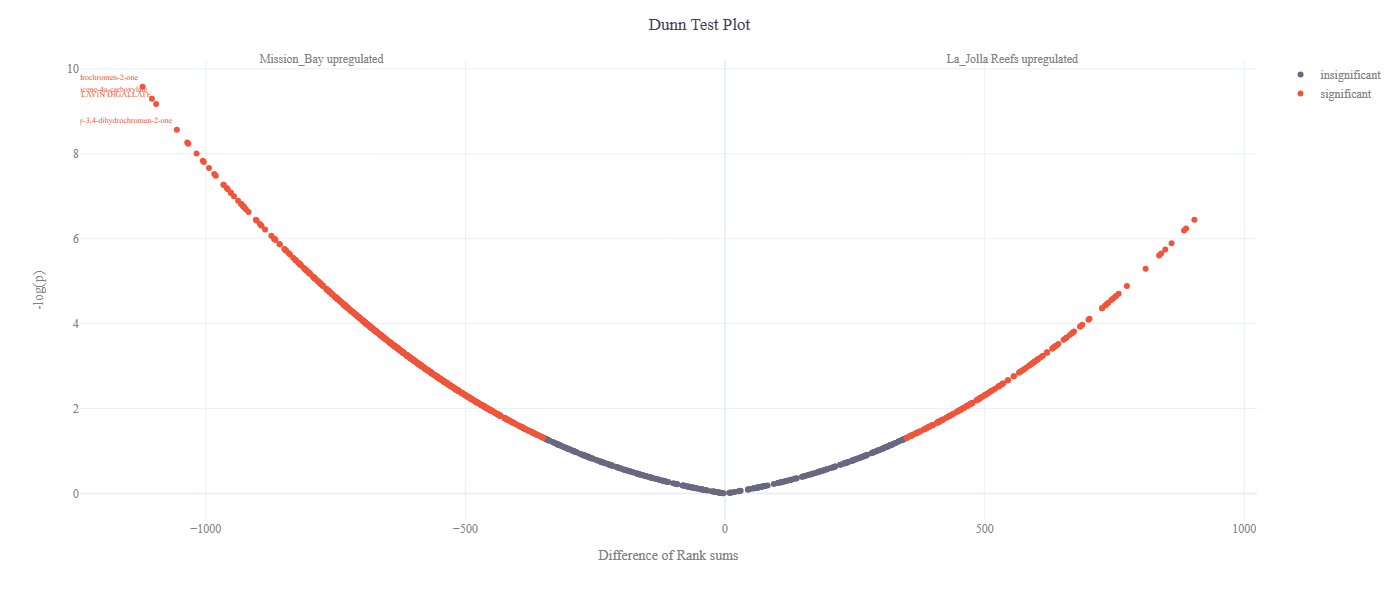

In [586]:
fig = px.scatter(template='plotly_white', width=1000, height=600)

# plot insignificant values
fig.add_trace(go.Scatter(x=dunn[dunn['stats_significant'] == False]['rank_sum_diff'],
                         y=dunn[dunn['stats_significant'] == False]['stats_p_bh'].apply(lambda x: -np.log10(x)),
                         mode='markers', marker_color='#696880', name='insignificant'))

# plot significant values
fig.add_trace(go.Scatter(x=dunn[dunn['stats_significant']]['rank_sum_diff'],
                         y=dunn[dunn['stats_significant']]['stats_p_bh'].apply(lambda x: -np.log10(x)),
                         mode='markers+text', text=kruskal['metabolite'].iloc[:4], textposition='top left',
                         textfont=dict(color='#ef553b', size=8), marker_color='#ef553b', name='significant'))

# Grabbing the groups from the first contrast
group_A = dunn['contrast'].str.split('-').str[0].iloc[0]
group_B = dunn['contrast'].str.split('-').str[1].iloc[0]

# Add annotations to the figure to indicate upregulated and downregulated groups
fig.add_annotation(
    x=0.85, # Position on x-axis (between 0 and 1)
    y=1.02, # Position on y-axis (between 0 and 1)
    xref="paper",
    yref="paper",
    text=f"{group_A} upregulated",
    showarrow=False
)

fig.add_annotation(
    x=0.15, # Position on x-axis (between 0 and 1)
    y=1.02, # Position on y-axis (between 0 and 1)
    xref="paper",
    yref="paper",
    text=f"{group_B} upregulated",
    showarrow=False
)

fig.update_layout(font={"color":"grey", "size":12, "family":"Sans"},
                  title={"text":"Dunn Test Plot", 'x':0.5, "font_color":"#3E3D53"},
                  xaxis_title="Difference of Rank sums", yaxis_title="-log(p)")

# save image as pdf
fig.write_image(os.path.join(result_dir, "DunnTest.pdf"), scale=3)

display(fig)

Also visualizing the boxplots of the top 2 significant metabolites on the **right tail of the volcano plot**:

In [587]:
rightside_top_metabolites_dunn = dunn[dunn['stats_significant']].sort_values('rank_sum_diff', ascending=False)['stats_metabolite'].iloc[:2]

for stats_metabolite in rightside_top_metabolites_dunn: 
    fig = px.box(cleaned_data_with_md, x=kruskal_attribute, y=stats_metabolite, color=kruskal_attribute)
    fig.update_layout(showlegend=False, title=stats_metabolite, xaxis_title="", yaxis_title="intensity", template="plotly_white", width=500)
    fig.show()

Visualizing the boxplots of the top 2 significant metabolites on the **left tail of the volcano plot**:

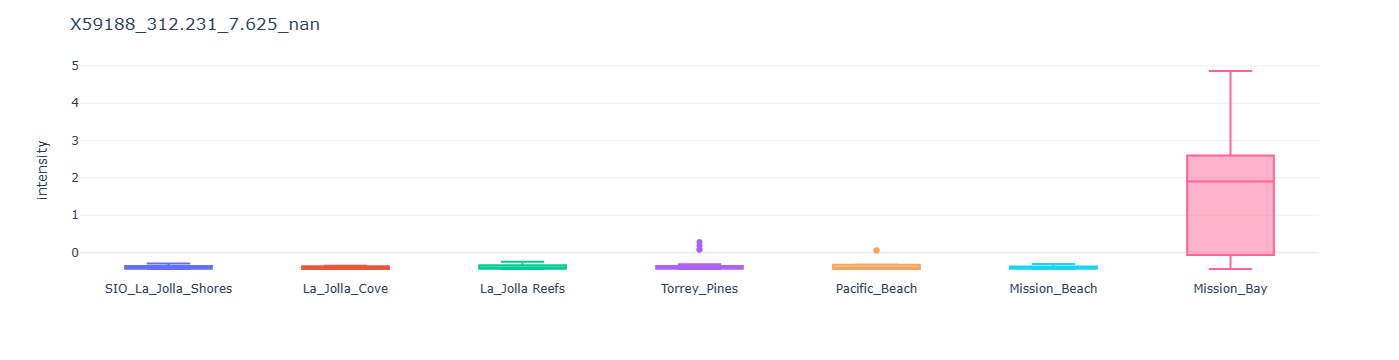

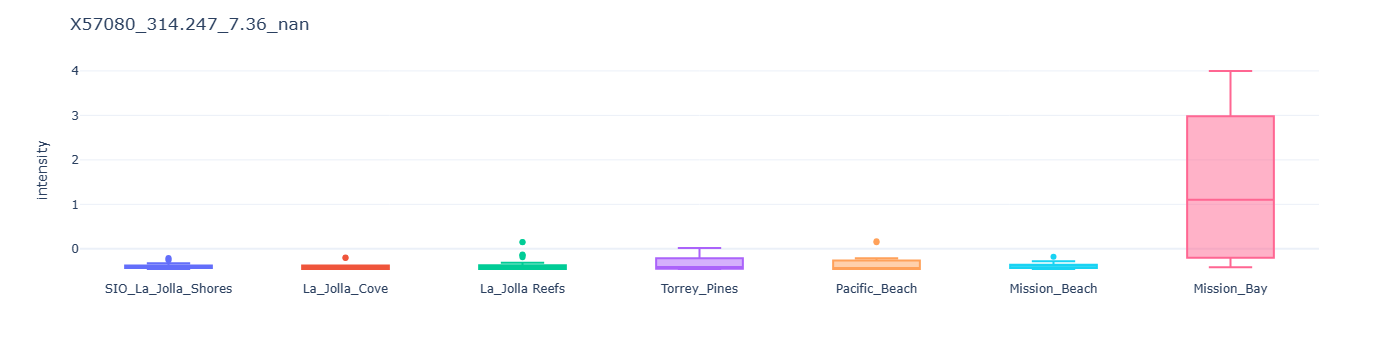

In [588]:
left_top_metabolites_dunn = dunn[dunn['stats_significant']].sort_values('rank_sum_diff')['stats_metabolite'].iloc[:2]

for stats_metabolite in left_top_metabolites_dunn: 
    fig = px.box(cleaned_data_with_md, x=kruskal_attribute, y=stats_metabolite, color=kruskal_attribute)
    fig.update_layout(showlegend=False, title=stats_metabolite, xaxis_title="", yaxis_title="intensity", template="plotly_white", width=500)
    fig.show()

# <font color = 'blue'>  7. Conclusion </font>
<a name="outro"></a>

### Step 76: Getting output files from Google Colab
For Google Collab users, we can zip the result folder which contains all the output files using the next cell and download the zip file directly from the folder "/content/My_TestData" into the local system.

In [ ]:
# Only for Google Colab
output_filename = '../TestData_Workflow_Results' # Specify the name and location of the output directory (here it will be in '/content/TestData_Workflow_Results')
dir_input = result_dir # Specify the directory to be zipped (here the Results directory specified in the beginning)
shutil.make_archive(output_filename, 'zip', dir_input)

This concludes all the analyses proposed in this work as essential for metabolomics data processing. While this workflow serves as a foundational guideline including many key tests, it was primarily constructed with a basic case study perspective and might not include all potential evaluations. Also a significant emphasis has been placed on ensuring this notebook's adaptability. While the examples utilize test data, the notebook is structured to be as flexible as possible, facilitating easy integration and adaptation with your own dataset.  

To get the most out of this notebook:

- Read the comments in the code.
- Check the package functions and their documentation if you have any doubt about how each function works and how changing parameters might be appropiate for your particular data.
- If something isn't clear or isn't working, ask for help on our GitHub page. Whether it's a query, a suggestion, or feedback, we value your interaction.
- Lastly, if this notebook is used in your research or projects, we kindly ask that you acknowledge our work. [Note: The bioarxiv link will soon be provided.] Finally, it is important to get the information of the Python session used for running the analyses. The 'Python session' data includes the version of the Python environment and the loaded packages. This information is useful for debugging purposes. If you raise any issues or questions in the GitHub page of this notebook, please, include the session.info details. It will help us help you better.

In [589]:
session_info.show() # To see all the information about the current Python session